In [79]:
import yaml
from yaml.loader import SafeLoader
from socket import gethostname
import numpy as np
from dev_interaction_util import generate_synthetic_dev_outcomes, generate_synthetic_dev_data
from ml_util import *

print(gethostname())
# Open the file and load the file
with open('config.yml') as f:
    all_yaml = yaml.load(f, Loader=SafeLoader)
    if gethostname() in all_yaml.keys():
        config = all_yaml[gethostname()]
    else:
        config = all_yaml['default']
        
print(config)



Benjamins-MacBook-Pro-2.local
{'dropbox_data_dir': '/Users/benjaminsmith/Dropbox (University of Oregon)/UO-SAN Lab/Berkman Lab/Devaluation/analysis_files/data/'}


This notebook is derived from pre_registered_preview.ipynb.

The aim is to look at how the model pipeline does with different sets of ground truths. If we plug in five actual effects, or ten, or twenty, how many are actually identified and how many irrelevant effects are identified?

This can't be too black and white, because of course in real life, teh features are correlated iwth one another. But at least, the features we select to be correlated should _actually be_ the most correlated.

In [80]:
dropbox_data_dir = config['dropbox_data_dir']


# Introduction
This is a pre-registered analysis for measuring moderations of the intervention.

We'll cross-validate the intervention moderations.

For this analysis, we'll try to make predictions based on some synthetic data. we'll take wave 1 data and randomly mix in changes based on our predictors, then try to model how we would predict those things. Finally, we'll make the predictions.

# Load data

In [81]:
import pandas as pd

data_by_ppt_path = dropbox_data_dir + '/data_by_ppt.csv'
data_codebook_path = dropbox_data_dir + 'data_codebook.csv'




In [82]:
data_by_ppt = pd.read_csv(data_by_ppt_path)
data_codebook = pd.read_csv(data_codebook_path)

In [83]:
#find out which columns in data_by_ppt are missing from the codebook
data_by_ppt.columns.difference(data_codebook['VarName'])


#copy our outcome measures, bf_1 and FFQ_1, into a new dataframe
data_by_ppt['bf_2'] = data_by_ppt.bf_1
#need to decide what sort of FFQ we want to use
data_by_ppt['cancer_promoting_minus_preventing_FFQ_1'] = data_by_ppt.cancer_promoting_minus_preventing_FFQ
data_by_ppt['cancer_promoting_minus_preventing_FFQ_2'] = data_by_ppt.cancer_promoting_minus_preventing_FFQ

# do a report on missing data
analysis_data  = data_by_ppt.loc[:,data_codebook.loc[data_codebook.IsSelectedPredictor,"VarName"]].copy()
outcome_measures = data_by_ppt.loc[:,data_codebook.loc[data_codebook.IsSelectedOutcomeMeasure,"VarName"]].copy()

na_values = pd.DataFrame(data_by_ppt.isna().sum())
na_values.columns = ['NA_Count']
na_values['prop_NA'] = na_values.NA_Count / data_by_ppt.shape[0]
data_codebook = data_codebook.merge(na_values, left_on='VarName', right_index=True)

data_codebook.to_csv(dropbox_data_dir + 'data_metadata.csv', index=False)

Need to count the number of valid and missing entries in each of our data predictors

## Converting data to numeric format

In [84]:
one_hot_vals = pd.get_dummies(analysis_data.birthsex_factor)
#there's only two variables here so we can convert this into a dummy variable
analysis_data.drop(columns=['birthsex_factor'], inplace=True)
one_hot_vals.columns = ['birthsex_factor_' + str(col) for col in one_hot_vals.columns]
analysis_data = analysis_data.join(one_hot_vals.iloc[:,1:])

In [85]:
analysis_data

,BSCS,EDM,BIS_11,PCS,RS,TRSQ,ACES_neglectful_parenting,ACES_abuse,ACES_sum,ACES_divorced_separated,...,zipcode_median_income_acs,household_income_per_person,SST_prop_successful_stops,SST_GRTmean,SST_SSD,SST_PostErrorSlowW1_mean,SST_mean_ssrt_0,ROC_Crave_Regulate_Minus_Look,WTP_unhealthy_minus_healthy,birthsex_factor_Male
0,2.538462,3.250,72,7.0,20.0,63.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5125,-0.312500,1
1,2.384615,1.750,89,9.0,22.0,63.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.440524,0
2,3.384615,2.500,63,9.0,18.0,57.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.500000,533.315052,284.375,0.058297,0.247061,-0.8000,-0.190476,0
3,3.076923,2.800,75,NaN,NaN,64.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.312500,498.167248,103.125,0.027730,0.446583,-0.8000,0.170363,0
4,3.307692,2.750,64,12.0,21.0,55.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.562500,626.507764,250.000,0.105660,0.369308,-1.5500,-0.494624,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,3.461538,4.000,58,18.0,17.0,54.0,0.0,1.0,3.0,1.0,...,-0.690347,1.768485,0.523438,NaN,NaN,NaN,0.357362,-0.0125,-1.008152,1
271,3.692308,3.875,54,17.0,13.0,55.0,2.0,2.0,5.0,0.0,...,-0.511475,-0.234851,0.492188,NaN,NaN,NaN,0.335849,-0.1500,-1.889247,1
272,3.461538,3.125,69,11.0,13.0,53.0,1.0,1.0,6.0,1.0,...,1.335248,0.099038,0.507812,NaN,NaN,NaN,0.273736,NaN,0.516129,1
273,2.846154,3.000,62,15.0,22.0,84.0,0.0,1.0,4.0,1.0,...,0.855379,-0.234851,0.479167,NaN,NaN,NaN,0.401098,-0.9875,-0.151210,0


# Missing data 

Apply missing data imputation to columns including cSES, ACES_sum, ses_aggregate, zipcode_median_income_acs, IMI, mcarthur social standing, based on demographic and self-report predictors.

In [86]:
# Imputing with MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn import linear_model
from ml_util import get_data_for_imputation



In [87]:
# import importlib
# importlib.reload(ml_util)


Based on this experiment, I'm going for Ridge regression with 10 nearest features. The values it imputes are a compromise between simply using the nearest mean, which is conservative when using these values for prediction because it doesn't introduce erroneous variance, but isn't very informative, and then using all available information, which Ridge regression with an unlimited number of features would do. It's a tough choice between this and KNN, which doesn't assume normality. Overall I'm going with KNN, because it picks up on relationships between the two variables while not generating extreme values like KNN seems to do.

In [88]:
imputer = IterativeImputer(estimator=linear_model.Ridge(),n_nearest_features=10,max_iter=100,random_state=0)
analysis_data_imputed = get_data_for_imputation(analysis_data)

#this dataset is already filtered for columns so we don't need to filter those further.
analysis_data_imputed = pd.DataFrame(imputer.fit_transform(analysis_data_imputed), columns=analysis_data_imputed.columns)
imputed_datapoint = analysis_data.isna()
# do_aces_cses_imputation_diagnostic(analysis_data_imputed, imputed_datapoint,'ridge_10')


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [89]:
# Base run

# Base run

This is my first go with this pipeline, running it much like I did in `pre_registered_preview.ipynb`.

Every data point has normally distributed influence on the outcome.

## Add synthetic data: run 1

### synthetic condition mediator

In [90]:
#set np random seed
np.random.seed(3161527)

In [91]:
group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])



### synthetic outcome variables

Which variables will we test to predict? We need to select variables from the following groups:

 - self-report variables
 - demographic variables we'll test
 - summaries of neural activities from each of WTP, SST, and ROC
 - summaries of behavioral data from each of WTP, SST, and ROC




In [92]:
outcome_measures = generate_synthetic_dev_outcomes(outcome_measures)

### add synthetic primary and interaction effects

In [93]:

synthetic_data = generate_synthetic_dev_data(analysis_data_imputed, group_assignments,outcome_measures, group_interaction_effects = None)
interaction_effect_df = synthetic_data['X_weights']
outcome_measures = synthetic_data['y']


['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

## Further preprocessing

These steps are performed on the data regardless of whether we are using synthetic data or real data.

### Set up outcome measures and group assignment one-hot





In [94]:
outcome_measures = calculate_outcome_changes(outcome_measures)

In [95]:
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

In [96]:
outcome_measures.loc[:,['bf_1','bf_2','d_bf']]

,bf_1,bf_2,d_bf
0,33.0,121.373628,88.373628
1,NaN,NaN,NaN
2,39.8,58.983743,19.183743
3,40.8,40.022751,-0.777249
4,47.6,-33.046255,-80.646255
...,...,...,...
270,29.9,31.240484,1.340484
271,33.1,28.992403,-4.107597
272,27.4,51.350718,23.950718
273,42.1,64.553479,22.453479


### Set up data

In [97]:

def set_up_interactions(predictor_data, group_assignment_onehots):
    #predictor_data = analysis_data_imputed
    predictor_data_columns = predictor_data.columns
    predictor_data_array = np.array(predictor_data)
    predictor_data = pd.concat([predictor_data,group_assignment_onehots],axis=1)
    for group_name in group_assignment_onehots.columns:

        #do a matrix multiplication of the group assignment onehot with the analysis data
        #repeat the group assignment onehot for each column in the analysis data
        
        interaction_array = predictor_data_array*np.array(group_assignment_onehots[group_name],ndmin=2).T
        interaction_df = pd.DataFrame(interaction_array, columns= [(c + '*'+group_name) for c in predictor_data_columns])
        print(interaction_df.shape)
        #then add the result to the analysis data
        predictor_data = pd.concat([predictor_data,interaction_df],axis=1)

    return(predictor_data)

predictor_data = set_up_interactions(analysis_data_imputed, group_assignment_onehots)





(275, 76)
(275, 76)


In [98]:
#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]
group_assignment_onehots_nonan = group_assignment_onehots.loc[~outcome_nas,:]
group_assignments_nona = group_assignments[~outcome_nas]


In [99]:
outcome_measures_nona['d_bf']

0      88.373628
2      19.183743
3      -0.777249
4     -80.646255
6       0.827321
         ...    
270     1.340484
271    -4.107597
272    23.950718
273    22.453479
274    23.806888
Name: d_bf, Length: 270, dtype: float64

## optimizing ridge regression using nested cross-validation

### IndependentVarStratifiedKFold function

In [100]:
from sklearn.utils.validation import column_or_1d
from sklearn.utils import check_random_state
from sklearn.utils.multiclass import type_of_target
from sklearn.model_selection import StratifiedKFold
import numpy as np
import warnings
from ml_util import IndependentVarStratifiedKFold


### Building a function to do CV

In [101]:
import numpy as np
#import clone
from sklearn.base import clone

def do_hyperparameter_selection_on_fold_grid_and_lasso(X, y,cv,alpha_range):
    if alpha_range is None:
        alpha_10pow_lower = 6
        alpha_10pow_upper = -1
        alpha_increments=1
        alpha_range = np.power(10,np.linspace(-alpha_10pow_lower,alpha_10pow_upper,(alpha_10pow_lower+alpha_10pow_upper)*alpha_increments+1))

    ############
    #RIDGE
    ridge_parameters = {'alpha':alpha_range}
    ridge_model = linear_model.Ridge()
    print(ridge_parameters)
    #do a gridsearch, using the same folds as the outer loop
    ridge_grid_search_cv = GridSearchCV(estimator=get_estimator_with_preprocessing(ridge_model), param_grid = get_param_grid_with_preprocessing(ridge_parameters), cv=cv,scoring='neg_mean_absolute_error')
    ridge_grid_search_cv.fit(X,y)

    ############
    #LASSO
    lasso_parameters = {'alpha':alpha_range}
    lasso_model = linear_model.Lasso()
    print(lasso_parameters)
    lasso_grid_search_cv = GridSearchCV(estimator=get_estimator_with_preprocessing(lasso_model), param_grid = get_param_grid_with_preprocessing(lasso_parameters), cv=cv,scoring='neg_mean_absolute_error')
    lasso_grid_search_cv.fit(X,y)



    all_cv_results = [ridge_grid_search_cv, lasso_grid_search_cv]

    #create a dataframe with the best parameters, best mean_test_score, and name of the model

    best_params_df = pd.DataFrame({
        'model': [cv_result.estimator for cv_result in all_cv_results],
        'model_name': [cv_result.estimator.__class__.__name__ for cv_result in all_cv_results],
        'best_params': [extract_estimator_params_from_gridsearch(cv_result.best_params_) for cv_result in all_cv_results],
        'best_score': [cv_result.best_score_ for cv_result in all_cv_results],
        'best_raw_params' : [cv_result.best_params_ for cv_result in all_cv_results]
        })
    
    best_params_df = best_params_df.sort_values('best_score',ascending=False).reset_index(drop=True)

    best_model = clone(best_params_df['model'][0])
    best_model_params = best_params_df['best_raw_params'][0]
    best_model.set_params(**best_model_params)

    return {
        'best_model': best_model,
        'best_params_df':best_params_df,
        'raw_cv_results':all_cv_results
    }





### Try out CV with simple gridsearch

In [102]:
from sklearn.model_selection import StratifiedKFold
import numpy as np




def do_scoring_loop(X, y, groups,hyperparameter_selection_on_fold,outer_folds):
  outer_splits = outer_folds
  inner_splits = outer_splits - 1

  outer_cv = IndependentVarStratifiedKFold(independent_vars=group_assignments_nona, n_splits=outer_splits, shuffle=True, random_state=3211050)
  #hold up. how does cross_val_score manage with an outer and inner CV that are defined at the same time?
  #maybe it doesn't matter.



  scores = []

  best_models = []
  best_params_df_list = []
  raw_cv_results_list = []
  # now do cv.split and print the items in each fold
  for i, (train_i, test_i) in enumerate(outer_cv.split(X, y)):
      print("outer split" + str(i))

      #test to see if this works on the group assignments
      # print("train:"+ str(dict(pd.Series(groups[train_i]).value_counts())) + ", " + 
      #       "test:" + 
      #     str(dict(pd.Series(groups[test_i]).value_counts()))
      # )

      train_i_X = X.iloc[train_i]
      train_i_y = y.iloc[train_i]
      train_i_group_assignments = groups[train_i]
      #print(train_i_y)

      test_i_X = X.iloc[test_i]
      test_i_y = y.iloc[test_i]
      #print(test_i_y)

      inner_cv = IndependentVarStratifiedKFold(independent_vars=train_i_group_assignments, n_splits=inner_splits, shuffle=True, random_state=3211050)

      selection_info = hyperparameter_selection_on_fold(train_i_X, train_i_y,cv = inner_cv)
      best_model_i = selection_info['best_model']
      best_params_i = selection_info['best_params_df']
      best_models.append(best_model_i)
      best_params_df_list.append(best_params_i)
      raw_cv_results_list.append(selection_info['raw_cv_results'])

      best_model_i.fit(train_i_X, train_i_y)
      score_r2_i = best_model_i.score(test_i_X, test_i_y)

      scores.append(score_r2_i)

  return({
      'scores':scores,
      'best_models':best_models,
      'best_params_df_list':best_params_df_list,
      'raw_cv_results_list':raw_cv_results_list
  })


In [103]:



scoring_data = do_scoring_loop(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], 
                groups = group_assignments_nona, 
                hyperparameter_selection_on_fold=do_hyperparameter_selection_on_fold_grid_and_lasso,
                outer_folds=4)

scores = scoring_data['scores']
best_models = scoring_data['best_models']
best_params_df_list = scoring_data['best_params_df_list']
raw_cv_results_list = scoring_data['raw_cv_results_list']

outer split0


TypeError: do_hyperparameter_selection_on_fold_grid_and_lasso() missing 1 required positional argument: 'alpha_range'

In [ ]:
print(scores)
overall_score = np.mean(scores)

[0.592648036767075, 0.8637179384108687, 0.4702976187483462, 0.6156636493141778]


In [ ]:
warnings.warn("Need to test how this runs with different numbers of variables because I'm getting wildly varying performance scores.")

/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_9881/2883780537.py:1: UserWarning: Need to test how this runs with different numbers of variables because I'm getting wildly varying performance scores.
  warnings.warn("Need to test how this runs with different numbers of variables because I'm getting wildly varying performance scores.")


In [ ]:
overall_score

0.635581810810117

Now we need to pick the best model, including model parameters. Two ways to do it; one is to follow the way its done in CV; the otehr is to do it like this:

 - We use each fold to 'vote' for a model, including the particular parameters used.
 - Possibly it will be a tie in that there will be two or more models with specific parameters that are chosen as best; possibly every single fold will have selected a slightly different set of parameters. In that case, if two or more models are 'first equal', eliminate the others, then select the model that got the highest test performance.

Now if we followed how it's one in CV, perhaps we just run GridSearchCV one more time, across the entire dataset, to select model parameters. hmm. That is _definitely_ going to over-fit, but I'm not sure it will be biased to choose excessive precision, because we'll still be doing train/test analysis.


Alternatively we could just use the data that GridSearchCV has _already generated_ to select the best model, by (I assume) adding up the performance for each model over the whole GridSearch and picking the best one. That would involve extracting performance for _every single model_ across ALL GridSearches and then combining them.

In [ ]:
def summarize_overall_df_results(raw_cv_results_list):
    cv_results_list = []
    for i, raw_result_fold_i in enumerate(raw_cv_results_list):
        for gsm in raw_cv_results_list[i]:
            gsm_j_cv_results_df = pd.DataFrame(gsm.cv_results_)
            gsm_j_cv_results_df['fold'] = i
            gsm_j_cv_results_df['model_description'] = str(gsm.estimator.named_steps.values())
            gsm_j_cv_results_df['model'] = gsm.estimator
            
            cv_results_list.append(gsm_j_cv_results_df)

    cv_results_df = pd.concat(cv_results_list)
    cv_results_df['params_str'] = cv_results_df['params'].astype(str)
    return(cv_results_df)

## Fit model

In [ ]:
from IPython.display import display, HTML
def get_best_model(cv_results_df):
    #group by model_description and params across folds and get the mean and std of the mean and std test scores
    performance_list = (
        cv_results_df
    .groupby(['model_description','params_str'])
    .agg({'mean_test_score':['mean','std'],'std_test_score':['mean','std']})
    )

    list_model_performance = (performance_list
    .sort_values(('mean_test_score','mean'),ascending=False)
    )

    #print the list in an html format that will look pretty in jupyter
    display(HTML(list_model_performance.to_html()))

    overall_fits =  performance_list.reset_index()

    #identify the index of best fit
    best_fit_description = overall_fits[overall_fits[('mean_test_score','mean')]==overall_fits[('mean_test_score','mean')].max()]

    best_fit_characteristics =  cv_results_df.loc[((cv_results_df['model_description']==best_fit_description['model_description'].values[0]) & 
                   (cv_results_df['params_str']==best_fit_description['params_str'].values[0])),:].iloc[0]
    
    best_model = clone(best_fit_characteristics.model)
    best_model_params = best_fit_characteristics.params
    best_model.set_params(**best_model_params)
    return(best_model)

    

In [ ]:
best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))

Now, estimate based on ALL the data to get a set of regressors we can report.

In [ ]:
def do_final_fit(X,y,final_model):
    final_fit = best_model.fit(X,y)
    
    return(final_fit)

final_fit = do_final_fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], final_model=best_model)

/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.916e+03, tolerance: 7.112e+01
  model = cd_fast.enet_coordinate_descent(


In [ ]:
def present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results):

    group_correlation_list = []
    for group_name in ['ichi','ni','san']:

        #print(group_name)
        group_data = predictor_data_nona.loc[group_assignments_nona==group_name,:]
        group_outcomes = outcome_measures_nona.loc[group_assignments_nona==group_name,'d_bf']

        
        
        #get the two-way correlation between data and the outcome column
        #these are what was actually modeled into the data.
        group_correlations = pd.DataFrame({group_name + '_cor':group_data[base_regressors].corrwith(group_outcomes)})
        #print(group_correlations)
        group_correlation_list.append(group_correlations)

    #concatenate the group correlations into a single dataframe
    group_correlations = pd.concat(group_correlation_list,axis=1)
    
    interaction_effect_labels = final_results.predictor.str.split("*",expand=True)
    interaction_effect_labels.columns = ['measure','group']

    #if the group column is empty, then it's a base effect. label it as such
    interaction_effect_labels.loc[interaction_effect_labels['group'].isna(),'group'] = 'base'

    #add the interaction effect labels to the final results
    final_results = pd.concat([final_results,interaction_effect_labels],axis=1)

    # reshape to wide format, with the group column as header adn coef as the values
    final_results_wide = final_results.pivot(index='measure',columns='group',values='coef')
    #merge the wide format with the group correlations
    #rows won't be in the same order so need to match the index names
    results_vs_cors = final_results_wide.merge(group_correlations, left_index=True, right_index=True, how='outer')
    #do a row sum of absolute values
    results_vs_cors['abs_effect_sum'] = np.sum(np.abs(results_vs_cors[['base','ni','san']]),axis=1)
    #sort by the absolute effect sum
    results_vs_cors.sort_values(by='abs_effect_sum',ascending=False,inplace=True)

    #get the number of the last row with a non-na correlation
    not_na_values = (~results_vs_cors['ichi_cor'].isna()).reset_index(drop=True)
    last_not_na = not_na_values[not_na_values].index[-1]

    #get the number of the last row with a non-zero effect

    not_zero_values = (results_vs_cors['abs_effect_sum']>0.001).reset_index(drop=True)
    last_not_zero = not_zero_values[not_zero_values].index[-1]

    last_line = np.min([last_not_na,last_not_zero])

    #print as HTML
    display(HTML(np.round(results_vs_cors.iloc[0:last_line+1,:],2).to_html()))


In [ ]:
def present_model_results(X,final_fit):
    final_estimator = final_fit.named_steps['estimator']
    #view the coefficients
    final_results = pd.DataFrame({
        'predictor': X.columns,
        'coef': final_estimator.coef_
        #'std_err': np.sqrt(np.diag(model_fit.coef_cov_)),
        #'pval': 2*(1-stats.t.cdf(np.abs(model_fit.coef_/np.sqrt(np.diag(model_fit.coef_cov_))),df=predictor_data_nona.shape[0]-predictor_data_nona.shape[1]))
    })

    final_results['coef_abs'] = np.abs(final_results.coef)
    final_results = final_results.sort_values('coef_abs',ascending=False)

    selected_features_count = np.sum(final_estimator.coef_!=0)
    print(f"Number of selected features: {selected_features_count}")

    display(HTML(final_results[0:20].to_html()))
    return(final_results)


In [ ]:
final_fit = do_final_fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], final_model=best_model)



/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.916e+03, tolerance: 7.112e+01
  model = cd_fast.enet_coordinate_descent(


In [ ]:
final_results = present_model_results(X=predictor_data_nona, final_fit=final_fit)

#print rows of final_results where feature_name is the list of features to check
base_regressors = interaction_effect_df.predictor[interaction_effect_df.interaction_effect!=0] #['BSCS','EDM','BIS_11','PCS', 'RS','TRSQ','ACES_neglectful_parenting','ACES_abuse']
regressors_to_check = [x+y for y in ['','*ni','*san'] for x in base_regressors]
final_results.loc[final_results['predictor'].isin(
    regressors_to_check
    ),:]

final_results['planned_regression'] = final_results['predictor'].isin(regressors_to_check)

present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results)

Number of selected features: 147


,predictor,coef,coef_abs
175,IMI_perceived_competence*san,-92.653269,92.653269
166,BFI_conscientiousness*san,-69.907954,69.907954
156,BIS_11*san,56.930420,56.930420
165,BFI_agreeableness*san,44.135155,44.135155
198,RMQ_lie*san,37.701315,37.701315
202,RTFS_factor_2*san,-35.764932,35.764932
196,PLAN_mental_forecasting*san,31.885478,31.885478
173,IMI_interest_enjoyment*san,29.979258,29.979258
80,BIS_11*ni,-27.818475,27.818475
158,RS*san,-23.947739,23.947739


,base,ni,san,ichi_cor,ni_cor,san_cor,abs_effect_sum
IMI_perceived_competence,-1.67,-0.91,-92.65,-0.04,0.11,-0.29,95.23
IMI_perceived_competence,-1.67,-0.91,-92.65,-0.04,0.11,-0.29,95.23
BIS_11,-1.27,-27.82,56.93,0.05,-0.42,0.13,86.02
BIS_11,-1.27,-27.82,56.93,0.05,-0.42,0.13,86.02
BFI_conscientiousness,-0.00,0.44,-69.91,-0.03,0.28,-0.15,70.35
BFI_conscientiousness,-0.00,0.44,-69.91,-0.03,0.28,-0.15,70.35
BFI_agreeableness,1.93,-0.00,44.14,-0.14,0.15,0.27,46.06
BFI_agreeableness,1.93,-0.00,44.14,-0.14,0.15,0.27,46.06
RMQ_lie,-0.64,-1.08,37.70,-0.14,0.16,0.16,39.42
RMQ_lie,-0.64,-1.08,37.70,-0.14,0.16,0.16,39.42


# Run 2

In [48]:
# Run 2
from sklearn.utils.validation import column_or_1d
from sklearn.utils import check_random_state
from sklearn.utils.multiclass import type_of_target
from sklearn.model_selection import StratifiedKFold
import numpy as np
import warnings
from ml_util import IndependentVarStratifiedKFold


#set np random seed
np.random.seed(3161527)

group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])

#synthetic outcomes
outcome_measures = generate_synthetic_dev_outcomes(outcome_measures)

# add synthetic primary and interaction effects


#set up the interaction effects
custom_interaction_effects_g1 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g1[0] = 0.5
custom_interaction_effects_g1[1] = -0.5
custom_interaction_effects_g1[2] = 0.25
custom_interaction_effects_g1[3] = -0.25

custom_interaction_effects_g2 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g2[4] = 0.5
custom_interaction_effects_g2[5] = -0.5
custom_interaction_effects_g2[6] = 0.25
custom_interaction_effects_g2[7] = -0.25

custom_interaction_effects = {'ni':custom_interaction_effects_g1,'san':custom_interaction_effects_g2}



synthetic_data = generate_synthetic_dev_data(analysis_data_imputed, group_assignments,outcome_measures, group_interaction_effects = custom_interaction_effects)
interaction_effect_df = synthetic_data['X_weights']
outcome_measures = synthetic_data['y']


['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

In [49]:
# Set up outcome measures and group assignment one-hot

outcome_measures = calculate_outcome_changes(outcome_measures)
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

# set up data


predictor_data = analysis_data_imputed
predictor_data_columns = predictor_data.columns
predictor_data_array = np.array(predictor_data)
predictor_data = pd.concat([predictor_data,group_assignment_onehots],axis=1)
for group_name in group_assignment_onehots.columns:

    #do a matrix multiplication of the group assignment onehot with the analysis data
    #repeat the group assignment onehot for each column in the analysis data
    
    interaction_array = predictor_data_array*np.array(group_assignment_onehots[group_name],ndmin=2).T
    interaction_df = pd.DataFrame(interaction_array, columns= [(c + '*'+group_name) for c in predictor_data_columns])
    print(interaction_df.shape)
    #then add the result to the analysis data
    predictor_data = pd.concat([predictor_data,interaction_df],axis=1)

    

#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]
group_assignment_onehots_nonan = group_assignment_onehots.loc[~outcome_nas,:]
group_assignments_nona = group_assignments[~outcome_nas]




(275, 76)
(275, 76)


In [51]:
### Try out CV with simple gridsearch



scoring_data = do_scoring_loop(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], 
                groups = group_assignments_nona, 
                hyperparameter_selection_on_fold=do_hyperparameter_selection_on_fold_grid_and_lasso,
                outer_folds=4
                )

scores = scoring_data['scores']
best_models = scoring_data['best_models']
best_params_df_list = scoring_data['best_params_df_list']
raw_cv_results_list = scoring_data['raw_cv_results_list']

print(scores)
overall_score = np.mean(scores)


best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))

outer split0
train:{'ni': 72, 'san': 65, 'ichi': 65}, test:{'ni': 24, 'san': 22, 'ichi': 22}
0      7.584797
3     -0.777249
6      0.827321
7      7.425306
8     -7.001130
         ...   
264   -3.951309
266    1.553740
267    3.344155
269    7.090017
270   -7.917137
Name: d_bf, Length: 202, dtype: float64
2      11.912788
4       9.943944
25      6.768641
29     -4.907638
32     -8.403221
         ...    
268     0.278630
271    -4.107597
272     1.632149
273    -3.380766
274    -3.366966
Name: d_bf, Length: 68, dtype: float64
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.101e+00, tolerance: 4.058e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.473e+00, tolerance: 4.570e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split1
train:{'ni': 72, 'san': 65, 'ichi': 65}, test:{'ni': 24, 'ichi': 22, 'san': 22}
0       7.584797
2      11.912788
4       9.943944
7       7.425306
9       4.993245
         ...    
270    -7.917137
271    -4.107597
272     1.632149
273    -3.380766
274    -3.366966
Name: d_bf, Length: 202, dtype: float64
3      -0.777249
6       0.827321
8      -7.001130
12     -9.872780
13      2.101033
         ...    
259    -0.527485
262    12.264821
264    -3.951309
266     1.553740
269     7.090017
Name: d_bf, Length: 68, dtype: float64
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.167e+00, tolerance: 4.302e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.302e+00, tolerance: 4.378e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split2
train:{'ni': 72, 'ichi': 66, 'san': 65}, test:{'ni': 24, 'san': 22, 'ichi': 21}
0       7.584797
2      11.912788
3      -0.777249
4       9.943944
6       0.827321
         ...    
269     7.090017
271    -4.107597
272     1.632149
273    -3.380766
274    -3.366966
Name: d_bf, Length: 203, dtype: float64
11      2.813867
15     -0.333162
21     -5.150849
23    -13.580715
27     -3.379550
         ...    
256    11.322333
257    -0.106228
263    -4.652017
267     3.344155
270    -7.917137
Name: d_bf, Length: 67, dtype: float64
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.480e-01, tolerance: 4.100e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.241e-01, tolerance: 4.164e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split3
train:{'ni': 72, 'san': 66, 'ichi': 65}, test:{'ni': 24, 'ichi': 22, 'san': 21}
2      11.912788
3      -0.777249
4       9.943944
6       0.827321
8      -7.001130
         ...    
270    -7.917137
271    -4.107597
272     1.632149
273    -3.380766
274    -3.366966
Name: d_bf, Length: 203, dtype: float64
0      7.584797
7      7.425306
9      4.993245
10     3.070869
17     3.023129
         ...   
248    3.242029
251   -9.612722
254    4.326857
258    3.863843
260    0.032767
Name: d_bf, Length: 67, dtype: float64
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.078e-01, tolerance: 4.165e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.016e+00, tolerance: 4.165e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

[-0.03980000471844014, -0.020114405616203035, 0.30112825385638875, 0.25835868269706386]


In [53]:
#run 2 fit
best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))
final_fit = do_final_fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], final_model=best_model)

In [58]:
final_results = present_model_results(X=predictor_data_nona, final_fit=final_fit)

#print rows of final_results where feature_name is the list of features to check
base_regressors = interaction_effect_df.predictor[interaction_effect_df.interaction_effect!=0] #['BSCS','EDM','BIS_11','PCS', 'RS','TRSQ','ACES_neglectful_parenting','ACES_abuse']
regressors_to_check = [x+y for y in ['','*ni','*san'] for x in base_regressors]
final_results.loc[final_results['predictor'].isin(
    regressors_to_check
    ),:]

final_results['planned_regression'] = final_results['predictor'].isin(regressors_to_check)

present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results)

Number of selected features: 70


,predictor,coef,coef_abs
159,TRSQ*san,-5.262940,5.262940
158,RS*san,5.000992,5.000992
79,EDM*ni,-3.983608,3.983608
78,BSCS*ni,2.663000,2.663000
105,NCS_avoid_depth*ni,1.608254,1.608254
160,ACES_neglectful_parenting*san,1.336333,1.336333
3,PCS,-1.243931,1.243931
60,RTFS_f1_minus_f2,-0.848334,0.848334
206,TESQ_E_controlling_temptations*san,0.798082,0.798082
5,TRSQ,-0.754610,0.754610


,base,ni,san,ichi_cor,ni_cor,san_cor,abs_effect_sum
TRSQ,-0.75,0.00,-5.26,0.09,0.00,-0.44,6.02
RS,0.14,-0.00,5.00,0.04,0.07,0.40,5.14
EDM,-0.31,-3.98,-0.00,0.05,-0.62,-0.24,4.30
BSCS,0.42,2.66,0.00,-0.14,0.03,0.01,3.09
PCS,-1.24,-0.56,0.00,-0.06,-0.45,-0.26,1.81
NCS_avoid_depth,0.00,1.61,0.00,NaN,NaN,NaN,1.61
ACES_neglectful_parenting,-0.00,-0.00,1.34,-0.05,-0.20,0.29,1.34
RTFS_factor_2,-0.40,0.01,-0.54,NaN,NaN,NaN,0.95
RTFS_f1_minus_f2,-0.85,-0.00,0.08,NaN,NaN,NaN,0.93
TESQ_E_controlling_temptations,-0.03,-0.00,0.80,NaN,NaN,NaN,0.82


# Run 3

In [87]:

#set np random seed
np.random.seed(3161527)

group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])

#synthetic outcomes
outcome_measures = generate_synthetic_dev_outcomes(outcome_measures)

# add synthetic primary and interaction effects


#set up the interaction effects
custom_interaction_effects_g1 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g1[0] = 0.5
custom_interaction_effects_g1[1] = 0.5
custom_interaction_effects_g1[2] = 0.5
custom_interaction_effects_g1[3] = 0.5

custom_interaction_effects_g2 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g2[4] = 0.5
custom_interaction_effects_g2[5] = 0.5
custom_interaction_effects_g2[6] = 0.5
custom_interaction_effects_g2[7] = 0.5

custom_interaction_effects = {'ni':custom_interaction_effects_g1,'san':custom_interaction_effects_g2}



synthetic_data = generate_synthetic_dev_data(analysis_data_imputed, group_assignments,outcome_measures, group_interaction_effects = custom_interaction_effects)
interaction_effect_df = synthetic_data['X_weights']
outcome_measures = synthetic_data['y']

# Set up outcome measures and group assignment one-hot

outcome_measures = calculate_outcome_changes(outcome_measures)
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

# set up data


predictor_data = analysis_data_imputed
predictor_data_columns = predictor_data.columns
predictor_data_array = np.array(predictor_data)
predictor_data = pd.concat([predictor_data,group_assignment_onehots],axis=1)
for group_name in group_assignment_onehots.columns:

    #do a matrix multiplication of the group assignment onehot with the analysis data
    #repeat the group assignment onehot for each column in the analysis data
    
    interaction_array = predictor_data_array*np.array(group_assignment_onehots[group_name],ndmin=2).T
    interaction_df = pd.DataFrame(interaction_array, columns= [(c + '*'+group_name) for c in predictor_data_columns])
    print(interaction_df.shape)
    #then add the result to the analysis data
    predictor_data = pd.concat([predictor_data,interaction_df],axis=1)

    

#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]
group_assignment_onehots_nonan = group_assignment_onehots.loc[~outcome_nas,:]
group_assignments_nona = group_assignments[~outcome_nas]




### Try out CV with simple gridsearch

# outer_splits = 4
# inner_splits = outer_splits - 1

# outer_cv = IndependentVarStratifiedKFold(independent_vars=group_assignments_nona, n_splits=outer_splits, shuffle=True, random_state=3211050)
#hold up. how does cross_val_score manage with an outer and inner CV that are defined at the same time?
#maybe it doesn't matter.


scoring_data = do_scoring_loop(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], 
                groups = group_assignments_nona, 
                hyperparameter_selection_on_fold=do_hyperparameter_selection_on_fold_grid_and_lasso,
                outer_folds = 4)

scores = scoring_data['scores']
best_models = scoring_data['best_models']
best_params_df_list = scoring_data['best_params_df_list']
raw_cv_results_list = scoring_data['raw_cv_results_list']

print(scores)
overall_score = np.mean(scores)


best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.456e+00, tolerance: 1.075e+00
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.435e+00, tolerance: 9.549e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split1
train:{'ni': 72, 'san': 65, 'ichi': 65}, test:{'ni': 24, 'ichi': 22, 'san': 22}
0       5.557285
2      -1.859708
4       1.290509
7      -0.969368
9      -8.889730
         ...    
270     7.480148
271    -4.107597
272    -4.322267
273    16.650342
274   -17.082558
Name: d_bf, Length: 202, dtype: float64
3      -0.777249
6       0.827321
8      15.704533
12     -9.872780
13      2.101033
         ...    
259    -5.398658
262     2.721799
264   -12.719901
266     1.553740
269    -8.272148
Name: d_bf, Length: 68, dtype: float64
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.484e+00, tolerance: 1.187e+00
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.808e+00, tolerance: 9.701e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split2
train:{'ni': 72, 'ichi': 66, 'san': 65}, test:{'ni': 24, 'san': 22, 'ichi': 21}
0       5.557285
2      -1.859708
3      -0.777249
4       1.290509
6       0.827321
         ...    
269    -8.272148
271    -4.107597
272    -4.322267
273    16.650342
274   -17.082558
Name: d_bf, Length: 203, dtype: float64
11      2.813867
15      4.614439
21      1.135264
23     16.255606
27     -2.886725
         ...    
256   -10.822231
257    -6.700433
263    -8.473609
267     3.344155
270     7.480148
Name: d_bf, Length: 67, dtype: float64
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.160e+00, tolerance: 1.148e+00
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.825e+00, tolerance: 1.115e+00
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split3
train:{'ni': 72, 'san': 66, 'ichi': 65}, test:{'ni': 24, 'ichi': 22, 'san': 21}
2      -1.859708
3      -0.777249
4       1.290509
6       0.827321
8      15.704533
         ...    
270     7.480148
271    -4.107597
272    -4.322267
273    16.650342
274   -17.082558
Name: d_bf, Length: 203, dtype: float64
0       5.557285
7      -0.969368
9      -8.889730
10     -2.335619
17      3.611856
         ...    
248    -4.085801
251    -9.612722
254    -2.604687
258     3.863843
260    10.102556
Name: d_bf, Length: 67, dtype: float64
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.729e+00, tolerance: 1.279e+00
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.412e+00, tolerance: 1.029e+00
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

[0.5337349140064107, 0.5274472450846487, 0.5811912918622398, 0.6314670581176234]


In [88]:
#run 3 fit
best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))
final_fit = do_final_fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], final_model=best_model)

final_results = present_model_results(X=predictor_data_nona, final_fit=final_fit)

#print rows of final_results where feature_name is the list of features to check
base_regressors = interaction_effect_df.predictor[interaction_effect_df.interaction_effect!=0]
regressors_to_check = [x+y for y in ['','*ni','*san'] for x in base_regressors]
final_results.loc[final_results['predictor'].isin(
    regressors_to_check
    ),:]

final_results['planned_regression'] = final_results['predictor'].isin(regressors_to_check)





Number of selected features: 84


,predictor,coef,coef_abs
158,RS*san,7.408848,7.408848
83,TRSQ*ni,-6.587755,6.587755
79,EDM*ni,5.658218,5.658218
81,PCS*ni,5.521136,5.521136
204,SRHI_unhealthy*san,-4.229052,4.229052
154,BSCS*san,-3.184102,3.184102
160,ACES_neglectful_parenting*san,3.094373,3.094373
161,ACES_abuse*san,2.759917,2.759917
155,EDM*san,-1.877262,1.877262
159,TRSQ*san,1.565993,1.565993


In [89]:
present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results)

,base,ni,san,ichi_cor,ni_cor,san_cor,abs_effect_sum
TRSQ,1.19,-6.59,1.57,0.09,-0.27,0.45,9.35
RS,0.02,-0.53,7.41,0.04,-0.18,0.49,7.96
EDM,0.32,5.66,-1.88,0.05,0.70,-0.05,7.86
PCS,0.00,5.52,-0.00,-0.06,0.74,0.16,5.52
SRHI_unhealthy,0.23,-0.00,-4.23,NaN,NaN,NaN,4.46
ACES_abuse,0.78,0.00,2.76,0.15,0.36,0.62,3.54
BSCS,0.31,0.00,-3.18,-0.14,0.52,-0.17,3.49
ACES_neglectful_parenting,0.00,0.07,3.09,-0.05,0.23,0.64,3.16
NCS_intellectual_task,-0.35,-0.10,-0.88,NaN,NaN,NaN,1.34
NCS_avoid_depth,0.22,0.85,-0.00,NaN,NaN,NaN,1.07


# Run 4

In [90]:

#set np random seed
np.random.seed(3161527)

group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])

#synthetic outcomes
outcome_measures = generate_synthetic_dev_outcomes(outcome_measures)

# add synthetic primary and interaction effects


#set up the interaction effects
custom_interaction_effects_g1 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g1[0] = 0.2
custom_interaction_effects_g1[1] = 0.2
custom_interaction_effects_g1[2] = 0.2
custom_interaction_effects_g1[3] = 0.2

custom_interaction_effects_g2 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g2[4] = 0.2
custom_interaction_effects_g2[5] = 0.2
custom_interaction_effects_g2[6] = 0.2
custom_interaction_effects_g2[7] = 0.2

custom_interaction_effects = {'ni':custom_interaction_effects_g1,'san':custom_interaction_effects_g2}



synthetic_data = generate_synthetic_dev_data(analysis_data_imputed, group_assignments,outcome_measures, group_interaction_effects = custom_interaction_effects)
interaction_effect_df = synthetic_data['X_weights']
outcome_measures = synthetic_data['y']

# Set up outcome measures and group assignment one-hot

outcome_measures = calculate_outcome_changes(outcome_measures)
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

# set up data


predictor_data = analysis_data_imputed
predictor_data_columns = predictor_data.columns
predictor_data_array = np.array(predictor_data)
predictor_data = pd.concat([predictor_data,group_assignment_onehots],axis=1)
for group_name in group_assignment_onehots.columns:

    #do a matrix multiplication of the group assignment onehot with the analysis data
    #repeat the group assignment onehot for each column in the analysis data
    
    interaction_array = predictor_data_array*np.array(group_assignment_onehots[group_name],ndmin=2).T
    interaction_df = pd.DataFrame(interaction_array, columns= [(c + '*'+group_name) for c in predictor_data_columns])
    print(interaction_df.shape)
    #then add the result to the analysis data
    predictor_data = pd.concat([predictor_data,interaction_df],axis=1)

    

#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]
group_assignment_onehots_nonan = group_assignment_onehots.loc[~outcome_nas,:]
group_assignments_nona = group_assignments[~outcome_nas]




### Try out CV with simple gridsearch


scoring_data = do_scoring_loop(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], 
                groups = group_assignments_nona, 
                hyperparameter_selection_on_fold=do_hyperparameter_selection_on_fold_grid_and_lasso,
                outer_folds=4)

scores = scoring_data['scores']
best_models = scoring_data['best_models']
best_params_df_list = scoring_data['best_params_df_list']
raw_cv_results_list = scoring_data['raw_cv_results_list']

print("scores:")
print(scores)
overall_score = np.mean(scores)
print("overall_score:")
print(overall_score)



best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))

#run 3 fit
best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))
final_fit = do_final_fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], final_model=best_model)

final_results = present_model_results(X=predictor_data_nona, final_fit=final_fit)

#print rows of final_results where feature_name is the list of features to check
base_regressors = interaction_effect_df.predictor[interaction_effect_df.interaction_effect!=0]
regressors_to_check = [x+y for y in ['','*ni','*san'] for x in base_regressors]
final_results.loc[final_results['predictor'].isin(
    regressors_to_check
    ),:]

final_results['planned_regression'] = final_results['predictor'].isin(regressors_to_check)

present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.178e-01, tolerance: 2.944e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.175e-01, tolerance: 3.182e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split1
train:{'ni': 72, 'san': 65, 'ichi': 65}, test:{'ni': 24, 'ichi': 22, 'san': 22}
0      4.745847
2      2.599255
4      1.376994
7      1.509069
9      0.110775
         ...   
270    2.461719
271   -4.107597
272   -2.021175
273    8.072470
274   -8.381226
Name: d_bf, Length: 202, dtype: float64
3     -0.777249
6      0.827321
8      4.599093
12    -9.872780
13     2.101033
         ...   
259   -0.375485
262   -0.757633
264   -6.394392
266    1.553740
269   -1.905582
Name: d_bf, Length: 68, dtype: float64
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.246e-01, tolerance: 3.075e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.263e-01, tolerance: 3.103e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split2
train:{'ni': 72, 'ichi': 66, 'san': 65}, test:{'ni': 24, 'san': 22, 'ichi': 21}
0      4.745847
2      2.599255
3     -0.777249
4      1.376994
6      0.827321
         ...   
269   -1.905582
271   -4.107597
272   -2.021175
273    8.072470
274   -8.381226
Name: d_bf, Length: 203, dtype: float64
11     2.813867
15     5.633871
21     1.161655
23     7.464498
27    -4.238253
         ...   
256   -3.253296
257   -3.269806
263   -4.523924
267    3.344155
270    2.461719
Name: d_bf, Length: 67, dtype: float64
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.843e-01, tolerance: 3.304e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.330e-01, tolerance: 3.432e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split3
train:{'ni': 72, 'san': 66, 'ichi': 65}, test:{'ni': 24, 'ichi': 22, 'san': 21}
2      2.599255
3     -0.777249
4      1.376994
6      0.827321
8      4.599093
         ...   
270    2.461719
271   -4.107597
272   -2.021175
273    8.072470
274   -8.381226
Name: d_bf, Length: 203, dtype: float64
0      4.745847
7      1.509069
9      0.110775
10    -1.256099
17     2.593148
         ...   
248    0.024765
251   -9.612722
254    0.521373
258    3.863843
260    2.932998
Name: d_bf, Length: 67, dtype: float64
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.833e-01, tolerance: 3.832e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.152e-01, tolerance: 3.496e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

scores:
[0.12381909441235761, 0.04478807011351227, 0.01196319375014332, -0.09756626401076685]
overall_score:
0.02075102356631159


Number of selected features: 60


,predictor,coef,coef_abs
79,EDM*ni,1.804084,1.804084
81,PCS*ni,1.657767,1.657767
158,RS*san,1.447408,1.447408
161,ACES_abuse*san,0.982661,0.982661
160,ACES_neglectful_parenting*san,0.958980,0.958980
82,RS*ni,-0.699862,0.699862
104,NCS_thinking_not_exciting*ni,-0.666075,0.666075
204,SRHI_unhealthy*san,-0.625704,0.625704
145,household_income_per_person*ni,0.497314,0.497314
155,EDM*san,-0.490978,0.490978


,base,ni,san,ichi_cor,ni_cor,san_cor,abs_effect_sum
EDM,0.08,1.80,-0.49,0.05,0.51,-0.04,2.37
RS,0.19,-0.70,1.45,0.04,-0.15,0.40,2.34
PCS,-0.00,1.66,-0.00,-0.06,0.54,0.13,1.66
ACES_abuse,0.32,-0.00,0.98,0.15,0.21,0.52,1.30
ACES_neglectful_parenting,0.00,0.00,0.96,-0.05,0.16,0.49,0.96
NCS_intellectual_task,-0.34,-0.00,-0.47,NaN,NaN,NaN,0.81
NCS_thinking_not_exciting,-0.00,-0.67,-0.00,NaN,NaN,NaN,0.67
SRHI_unhealthy,0.00,-0.00,-0.63,NaN,NaN,NaN,0.63
household_income_per_person,0.00,0.50,0.10,NaN,NaN,NaN,0.59
NCS_new_solutions_to_problems,-0.00,-0.49,0.00,NaN,NaN,NaN,0.49


# Run 5

In [92]:

#set np random seed
np.random.seed(3161527)

group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])

#synthetic outcomes
outcome_measures = generate_synthetic_dev_outcomes(outcome_measures)

# add synthetic primary and interaction effects


#set up the interaction effects
custom_interaction_effects_g1 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g1[0] = 0.1
custom_interaction_effects_g1[1] = 0.1
custom_interaction_effects_g1[2] = 0.1
custom_interaction_effects_g1[3] = 0.1

custom_interaction_effects_g2 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g2[4] = 0.1
custom_interaction_effects_g2[5] = 0.1
custom_interaction_effects_g2[6] = 0.1
custom_interaction_effects_g2[7] = 0.1

custom_interaction_effects = {'ni':custom_interaction_effects_g1,'san':custom_interaction_effects_g2}



synthetic_data = generate_synthetic_dev_data(analysis_data_imputed, group_assignments,outcome_measures, group_interaction_effects = custom_interaction_effects)
interaction_effect_df = synthetic_data['X_weights']
outcome_measures = synthetic_data['y']

# Set up outcome measures and group assignment one-hot

outcome_measures = calculate_outcome_changes(outcome_measures)
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

# set up data


predictor_data = analysis_data_imputed
predictor_data_columns = predictor_data.columns
predictor_data_array = np.array(predictor_data)
predictor_data = pd.concat([predictor_data,group_assignment_onehots],axis=1)
for group_name in group_assignment_onehots.columns:

    #do a matrix multiplication of the group assignment onehot with the analysis data
    #repeat the group assignment onehot for each column in the analysis data
    
    interaction_array = predictor_data_array*np.array(group_assignment_onehots[group_name],ndmin=2).T
    interaction_df = pd.DataFrame(interaction_array, columns= [(c + '*'+group_name) for c in predictor_data_columns])
    print(interaction_df.shape)
    #then add the result to the analysis data
    predictor_data = pd.concat([predictor_data,interaction_df],axis=1)

    

#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]
group_assignment_onehots_nonan = group_assignment_onehots.loc[~outcome_nas,:]
group_assignments_nona = group_assignments[~outcome_nas]




### Try out CV with simple gridsearch


scoring_data = do_scoring_loop(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], 
                groups = group_assignments_nona, 
                hyperparameter_selection_on_fold=do_hyperparameter_selection_on_fold_grid_and_lasso,
                outer_folds=4)

scores = scoring_data['scores']
best_models = scoring_data['best_models']
best_params_df_list = scoring_data['best_params_df_list']
raw_cv_results_list = scoring_data['raw_cv_results_list']

print("scores:")
print(scores)
overall_score = np.mean(scores)
print("overall_score:")
print(overall_score)



best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))

#run 3 fit
best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))
final_fit = do_final_fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], final_model=best_model)

final_results = present_model_results(X=predictor_data_nona, final_fit=final_fit)

#print rows of final_results where feature_name is the list of features to check
base_regressors = interaction_effect_df.predictor[interaction_effect_df.interaction_effect!=0]
regressors_to_check = [x+y for y in ['','*ni','*san'] for x in base_regressors]
final_results.loc[final_results['predictor'].isin(
    regressors_to_check
    ),:]

final_results['planned_regression'] = final_results['predictor'].isin(regressors_to_check)

present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.996e-01, tolerance: 2.087e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.956e-01, tolerance: 2.396e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split1
train:{'ni': 72, 'san': 65, 'ichi': 65}, test:{'ni': 24, 'ichi': 22, 'san': 22}
0      4.520443
2      4.085577
4      1.401019
7      2.197539
9      2.610974
         ...   
270    0.788909
271   -4.107597
272   -1.381968
273    5.689672
274   -5.964133
Name: d_bf, Length: 202, dtype: float64
3     -0.777249
6      0.827321
8      1.514177
12    -9.872780
13     2.101033
         ...   
259    1.019874
262   -1.724164
264   -4.637266
266    1.553740
269    0.216607
Name: d_bf, Length: 68, dtype: float64
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.897e-01, tolerance: 2.086e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.192e-01, tolerance: 2.260e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split2
train:{'ni': 72, 'ichi': 66, 'san': 65}, test:{'ni': 24, 'san': 22, 'ichi': 21}
0      4.520443
2      4.085577
3     -0.777249
4      1.401019
6      0.827321
         ...   
269    0.216607
271   -4.107597
272   -1.381968
273    5.689672
274   -5.964133
Name: d_bf, Length: 203, dtype: float64
11     2.813867
15     5.917053
21     1.168985
23     4.534128
27    -4.688763
         ...   
256   -0.730318
257   -2.316832
263   -3.426764
267    3.344155
270    0.788909
Name: d_bf, Length: 67, dtype: float64
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.695e-01, tolerance: 2.416e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.179e-01, tolerance: 2.462e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split3
train:{'ni': 72, 'san': 66, 'ichi': 65}, test:{'ni': 24, 'ichi': 22, 'san': 21}
2      4.085577
3     -0.777249
4      1.401019
6      0.827321
8      1.514177
         ...   
270    0.788909
271   -4.107597
272   -1.381968
273    5.689672
274   -5.964133
Name: d_bf, Length: 203, dtype: float64
0      4.520443
7      2.197539
9      2.610974
10    -0.896258
17     2.310167
         ...   
248    1.394953
251   -9.612722
254    1.563393
258    3.863843
260    0.941408
Name: d_bf, Length: 67, dtype: float64
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.637e-01, tolerance: 2.589e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.622e-01, tolerance: 2.237e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

scores:
[-0.12562495704942722, -0.1606514639323844, -0.0962538735225924, -0.2650136064256998]
overall_score:
-0.16188597523252596


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.107e+01, tolerance: 2.447e-01
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 58


,predictor,coef,coef_abs
79,EDM*ni,0.917805,0.917805
161,ACES_abuse*san,0.596849,0.596849
145,household_income_per_person*ni,0.538594,0.538594
206,TESQ_E_controlling_temptations*san,0.520330,0.520330
46,RMQ_locomotion,0.468334,0.468334
81,PCS*ni,0.463522,0.463522
11,BFI_agreeableness,-0.396986,0.396986
30,NCS_think_minimally,-0.343865,0.343865
23,NCS_intellectual_task,-0.333422,0.333422
55,TESQ_E_goal_and_rule_setting,0.328243,0.328243


,base,ni,san,ichi_cor,ni_cor,san_cor,abs_effect_sum
EDM,0.00,0.92,-0.00,0.05,0.30,-0.03,0.92
ACES_abuse,0.12,-0.00,0.60,0.15,0.08,0.39,0.72
household_income_per_person,0.02,0.54,0.05,NaN,NaN,NaN,0.61
TESQ_E_controlling_temptations,-0.00,-0.00,0.52,NaN,NaN,NaN,0.52
RMQ_locomotion,0.47,0.00,0.00,NaN,NaN,NaN,0.47
PCS,-0.00,0.46,-0.00,-0.06,0.32,0.08,0.46
BFI_agreeableness,-0.40,0.00,-0.00,NaN,NaN,NaN,0.40
NCS_thinking_not_exciting,-0.15,-0.23,-0.00,NaN,NaN,NaN,0.38
NCS_prefer_little_thought,-0.09,0.00,-0.26,NaN,NaN,NaN,0.35
NCS_intellectual_task,-0.33,-0.00,-0.01,NaN,NaN,NaN,0.35


# Run 6

In [ ]:

#set np random seed
np.random.seed(3161527)

group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])

#synthetic outcomes
outcome_measures = generate_synthetic_dev_outcomes(outcome_measures)

# add synthetic primary and interaction effects


#set up the interaction effects
custom_interaction_effects_g1 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g1[0] = 0.25
custom_interaction_effects_g1[1] = 0.25
custom_interaction_effects_g1[2] = -0.25
custom_interaction_effects_g1[3] = -0.25

custom_interaction_effects_g2 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g2[4] = 0.25
custom_interaction_effects_g2[5] = 0.25
custom_interaction_effects_g2[6] = -0.25
custom_interaction_effects_g2[7] = -0.25

custom_interaction_effects = {'ni':custom_interaction_effects_g1,'san':custom_interaction_effects_g2}



synthetic_data = generate_synthetic_dev_data(analysis_data_imputed, group_assignments,outcome_measures, group_interaction_effects = custom_interaction_effects)
interaction_effect_df = synthetic_data['X_weights']
outcome_measures = synthetic_data['y']

# Set up outcome measures and group assignment one-hot

outcome_measures = calculate_outcome_changes(outcome_measures)
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

# set up data


predictor_data = analysis_data_imputed
predictor_data_columns = predictor_data.columns
predictor_data_array = np.array(predictor_data)
predictor_data = pd.concat([predictor_data,group_assignment_onehots],axis=1)
for group_name in group_assignment_onehots.columns:

    #do a matrix multiplication of the group assignment onehot with the analysis data
    #repeat the group assignment onehot for each column in the analysis data
    
    interaction_array = predictor_data_array*np.array(group_assignment_onehots[group_name],ndmin=2).T
    interaction_df = pd.DataFrame(interaction_array, columns= [(c + '*'+group_name) for c in predictor_data_columns])
    print(interaction_df.shape)
    #then add the result to the analysis data
    predictor_data = pd.concat([predictor_data,interaction_df],axis=1)

    

#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]
group_assignment_onehots_nonan = group_assignment_onehots.loc[~outcome_nas,:]
group_assignments_nona = group_assignments[~outcome_nas]




### Try out CV with simple gridsearch


scoring_data = do_scoring_loop(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], 
                groups = group_assignments_nona, 
                hyperparameter_selection_on_fold=do_hyperparameter_selection_on_fold_grid_and_lasso,
                outer_folds=10)

scores = scoring_data['scores']
best_models = scoring_data['best_models']
best_params_df_list = scoring_data['best_params_df_list']
raw_cv_results_list = scoring_data['raw_cv_results_list']

print("scores:")
print(scores)
overall_score = np.mean(scores)
print("overall_score:")
print(overall_score)



best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))

#run 3 fit
best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))
final_fit = do_final_fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], final_model=best_model)

final_results = present_model_results(X=predictor_data_nona, final_fit=final_fit)

#print rows of final_results where feature_name is the list of features to check
base_regressors = interaction_effect_df.predictor[interaction_effect_df.interaction_effect!=0]
regressors_to_check = [x+y for y in ['','*ni','*san'] for x in base_regressors]
final_results.loc[final_results['predictor'].isin(
    regressors_to_check
    ),:]

final_results['planned_regression'] = final_results['predictor'].isin(regressors_to_check)

present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results)

# Run 7

In [96]:

#set np random seed
np.random.seed(3161527)

group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])

#synthetic outcomes
outcome_measures = generate_synthetic_dev_outcomes(outcome_measures)

# add synthetic primary and interaction effects


#set up the interaction effects
custom_interaction_effects_g1 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g1[0] = 0.10
custom_interaction_effects_g1[1] = 0.10
custom_interaction_effects_g1[2] = -0.10
custom_interaction_effects_g1[3] = -0.10

custom_interaction_effects_g2 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g2[4] = 0.10
custom_interaction_effects_g2[5] = 0.10
custom_interaction_effects_g2[6] = -0.10
custom_interaction_effects_g2[7] = -0.10

custom_interaction_effects = {'ni':custom_interaction_effects_g1,'san':custom_interaction_effects_g2}



synthetic_data = generate_synthetic_dev_data(analysis_data_imputed, group_assignments,outcome_measures, group_interaction_effects = custom_interaction_effects)
interaction_effect_df = synthetic_data['X_weights']
outcome_measures = synthetic_data['y']

# Set up outcome measures and group assignment one-hot

outcome_measures = calculate_outcome_changes(outcome_measures)
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

# set up data


predictor_data = analysis_data_imputed
predictor_data_columns = predictor_data.columns
predictor_data_array = np.array(predictor_data)
predictor_data = pd.concat([predictor_data,group_assignment_onehots],axis=1)
for group_name in group_assignment_onehots.columns:

    #do a matrix multiplication of the group assignment onehot with the analysis data
    #repeat the group assignment onehot for each column in the analysis data
    
    interaction_array = predictor_data_array*np.array(group_assignment_onehots[group_name],ndmin=2).T
    interaction_df = pd.DataFrame(interaction_array, columns= [(c + '*'+group_name) for c in predictor_data_columns])
    print(interaction_df.shape)
    #then add the result to the analysis data
    predictor_data = pd.concat([predictor_data,interaction_df],axis=1)

    

#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]
group_assignment_onehots_nonan = group_assignment_onehots.loc[~outcome_nas,:]
group_assignments_nona = group_assignments[~outcome_nas]




### Try out CV with simple gridsearch


scoring_data = do_scoring_loop(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], 
                groups = group_assignments_nona, 
                hyperparameter_selection_on_fold=do_hyperparameter_selection_on_fold_grid_and_lasso,
                outer_folds=10)

scores = scoring_data['scores']
best_models = scoring_data['best_models']
best_params_df_list = scoring_data['best_params_df_list']
raw_cv_results_list = scoring_data['raw_cv_results_list']

print("scores:")
print(scores)
overall_score = np.mean(scores)
print("overall_score:")
print(overall_score)



best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))

#run 3 fit
best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))
final_fit = do_final_fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], final_model=best_model)

final_results = present_model_results(X=predictor_data_nona, final_fit=final_fit)

#print rows of final_results where feature_name is the list of features to check
base_regressors = interaction_effect_df.predictor[interaction_effect_df.interaction_effect!=0]
regressors_to_check = [x+y for y in ['','*ni','*san'] for x in base_regressors]
final_results.loc[final_results['predictor'].isin(
    regressors_to_check
    ),:]

final_results['planned_regression'] = final_results['predictor'].isin(regressors_to_check)

present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.182e+02, tolerance: 3.657e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e+02, tolerance: 3.778e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split1
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.624e+01, tolerance: 3.957e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.244e+02, tolerance: 3.891e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split2
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.525e+02, tolerance: 3.640e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.011e+02, tolerance: 3.716e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split3
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.610e+02, tolerance: 3.630e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.630e+02, tolerance: 3.702e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split4
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.736e+02, tolerance: 3.792e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.669e+02, tolerance: 3.691e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split5
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.168e+02, tolerance: 3.939e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e+02, tolerance: 3.998e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split6
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.080e+02, tolerance: 3.977e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.186e+02, tolerance: 3.733e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split7
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.145e+02, tolerance: 3.856e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.538e+01, tolerance: 3.731e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split8
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.439e+01, tolerance: 3.961e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.317e+02, tolerance: 3.871e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split9
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.241e+02, tolerance: 3.817e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.562e+02, tolerance: 3.947e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

scores:
[0.2250357265565438, -0.3619536274561894, -0.3299892815544214, -0.02945749086392402, -0.050986200027441475, -0.44159080715983134, 0.21838709621954788, -0.08823421819795962, -0.33182085728180843, -0.10064207198086095]
overall_score:
-0.1291251731746345


Number of selected features: 54


,predictor,coef,coef_abs
206,TESQ_E_controlling_temptations*san,0.854528,0.854528
78,BSCS*ni,0.847691,0.847691
79,EDM*ni,0.779994,0.779994
3,PCS,-0.628072,0.628072
145,household_income_per_person*ni,0.576306,0.576306
160,ACES_neglectful_parenting*san,-0.576224,0.576224
55,TESQ_E_goal_and_rule_setting,0.449240,0.449240
60,RTFS_f1_minus_f2,-0.367463,0.367463
30,NCS_think_minimally,-0.363292,0.363292
103,NCS_like_responsibility*ni,-0.345513,0.345513


,base,ni,san,ichi_cor,ni_cor,san_cor,abs_effect_sum
TESQ_E_controlling_temptations,-0.00,-0.00,0.85,NaN,NaN,NaN,0.85
BSCS,-0.00,0.85,-0.00,-0.14,0.34,-0.04,0.85
EDM,0.05,0.78,-0.00,0.05,0.20,-0.10,0.83
household_income_per_person,0.00,0.58,0.15,NaN,NaN,NaN,0.73
ACES_neglectful_parenting,-0.07,0.00,-0.58,-0.05,-0.04,-0.37,0.65
PCS,-0.63,-0.00,0.00,-0.06,-0.06,-0.05,0.63
TESQ_E_goal_and_rule_setting,0.45,0.00,0.00,NaN,NaN,NaN,0.45
RTFS_f1_minus_f2,-0.37,-0.00,-0.00,NaN,NaN,NaN,0.37
NCS_think_minimally,-0.36,-0.00,0.00,NaN,NaN,NaN,0.36
NCS_like_responsibility,-0.00,-0.35,-0.00,NaN,NaN,NaN,0.35


In [104]:
fit_results = best_model.fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'])
fit_results['estimator'].coef_

array([-0.        ,  0.04511344, -0.        , -0.62807194,  0.        ,
        0.        , -0.06993725, -0.        , -0.        ,  0.        ,
        0.        , -0.34405203, -0.        ,  0.        ,  0.        ,
        0.        ,  0.01570331,  0.00686946,  0.        ,  0.        ,
       -0.        , -0.01554467,  0.        , -0.22826667,  0.23354974,
       -0.        , -0.16277762,  0.        , -0.        ,  0.        ,
       -0.36329207, -0.        , -0.09283413,  0.        ,  0.        ,
       -0.04007871, -0.        , -0.        ,  0.        ,  0.08005839,
        0.        , -0.        ,  0.        ,  0.1282829 , -0.05398998,
       -0.02643857,  0.3298481 , -0.17434803, -0.        , -0.        ,
        0.        , -0.        , -0.        , -0.22932399, -0.16678519,
        0.44923975,  0.02912911, -0.        , -0.        , -0.14213829,
       -0.3674635 , -0.        , -0.        ,  0.        , -0.        ,
       -0.10614498,  0.        ,  0.        , -0.06934301, -0.  

This suggests that for correlations in the range of 0.3 we will be unable to substantially predict outcomes; with correlations this weak, it's difficult to make accurate predictions.

I don't know how to quantify this--mainly we're looking empirically at how good prediction is when you have a certain level of correlation between predictors and outcome in this dataset.

But overall this is a bad sign.

Wonder if we can deal with that convergence issue?

In [117]:
best_fit = clone(best_model).fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'])
lasso_model= Pipeline(steps=[('scaler', StandardScaler()), ('estimator', Lasso(alpha=0.001))])
lasso_model.fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'])
lasso_model= Pipeline(steps=[('scaler', StandardScaler()), ('estimator', Lasso(alpha=0.01))])
lasso_model.fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'])
lasso_model= Pipeline(steps=[('scaler', StandardScaler()), ('estimator', Lasso(alpha=0.1))])
lasso_model.fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'])

/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.960e+02, tolerance: 4.789e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.753e+02, tolerance: 4.789e-01
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()), ('estimator', Lasso(alpha=0.1))])

Seems like it only occurs with some alpha levels. In other words it doesn't actually happen with the model taht was selected in the end. So dealing with the convergence isn't the issue. However, we should probably be considering a larger alpha range.

# Run 8 - expanding alpha range

In [62]:
    

def do_hyperparameter_selection_on_fold_grid_and_lasso_xa(X,y,cv):
    alpha_10pow_lower = 6
    alpha_10pow_upper = 0
    alpha_increments=1
    alpha_range = np.concatenate([np.power(10,np.linspace(-alpha_10pow_lower,alpha_10pow_upper,(alpha_10pow_lower+alpha_10pow_upper)*alpha_increments+1)),
        [0.2,0.4,0.6,0.8,1.0]])
    return(do_hyperparameter_selection_on_fold_grid_and_lasso(X,y,cv,alpha_range))

In [63]:

#set np random seed
np.random.seed(3161527)

group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])

#synthetic outcomes
outcome_measures = generate_synthetic_dev_outcomes(outcome_measures)

# add synthetic primary and interaction effects


#set up the interaction effects
custom_interaction_effects_g1 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g1[0] = 0.25
custom_interaction_effects_g1[1] = 0.25
custom_interaction_effects_g1[2] = -0.25
custom_interaction_effects_g1[3] = -0.25

custom_interaction_effects_g2 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g2[4] = 0.25
custom_interaction_effects_g2[5] = 0.25
custom_interaction_effects_g2[6] = -0.25
custom_interaction_effects_g2[7] = -0.25

custom_interaction_effects = {'ni':custom_interaction_effects_g1,'san':custom_interaction_effects_g2}



synthetic_data = generate_synthetic_dev_data(analysis_data_imputed, group_assignments,outcome_measures, group_interaction_effects = custom_interaction_effects)
interaction_effect_df = synthetic_data['X_weights']
outcome_measures = synthetic_data['y']

# Set up outcome measures and group assignment one-hot

outcome_measures = calculate_outcome_changes(outcome_measures)
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

predictor_data = set_up_interactions(analysis_data_imputed, group_assignment_onehots)


#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]
group_assignment_onehots_nonan = group_assignment_onehots.loc[~outcome_nas,:]
group_assignments_nona = group_assignments[~outcome_nas]




### Try out CV with simple gridsearch


scoring_data = do_scoring_loop(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], 
                groups = group_assignments_nona, 
                hyperparameter_selection_on_fold=do_hyperparameter_selection_on_fold_grid_and_lasso_xa,
                outer_folds=10)

scores = scoring_data['scores']
best_models = scoring_data['best_models']
best_params_df_list = scoring_data['best_params_df_list']
raw_cv_results_list = scoring_data['raw_cv_results_list']

print("scores:")
print(scores)
overall_score = np.mean(scores)
print("overall_score:")
print(overall_score)



best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))
final_fit = do_final_fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], final_model=best_model)
final_results = present_model_results(X=predictor_data_nona, final_fit=final_fit)

#print rows of final_results where feature_name is the list of features to check
base_regressors = interaction_effect_df.predictor[interaction_effect_df.interaction_effect!=0]
regressors_to_check = [x+y for y in ['','*ni','*san'] for x in base_regressors]
final_results['planned_regression'] = final_results['predictor'].isin(regressors_to_check)

present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.169e+02, tolerance: 7.056e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.220e+02, tolerance: 7.075e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split1
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 2.e-01,
       4.e-01, 6.e-01, 8.e-01, 1.e+00])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 2.e-01,
       4.e-01, 6.e-01, 8.e-01, 1.e+00])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.939e+01, tolerance: 7.280e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.231e+02, tolerance: 7.018e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split2
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 2.e-01,
       4.e-01, 6.e-01, 8.e-01, 1.e+00])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 2.e-01,
       4.e-01, 6.e-01, 8.e-01, 1.e+00])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.546e+02, tolerance: 6.973e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.047e+02, tolerance: 6.809e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split3
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 2.e-01,
       4.e-01, 6.e-01, 8.e-01, 1.e+00])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 2.e-01,
       4.e-01, 6.e-01, 8.e-01, 1.e+00])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.605e+02, tolerance: 6.703e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.622e+02, tolerance: 6.768e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split4
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 2.e-01,
       4.e-01, 6.e-01, 8.e-01, 1.e+00])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 2.e-01,
       4.e-01, 6.e-01, 8.e-01, 1.e+00])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.725e+02, tolerance: 6.958e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.765e+02, tolerance: 7.083e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split5
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 2.e-01,
       4.e-01, 6.e-01, 8.e-01, 1.e+00])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 2.e-01,
       4.e-01, 6.e-01, 8.e-01, 1.e+00])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.198e+02, tolerance: 7.159e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.661e+02, tolerance: 7.289e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split6
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 2.e-01,
       4.e-01, 6.e-01, 8.e-01, 1.e+00])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 2.e-01,
       4.e-01, 6.e-01, 8.e-01, 1.e+00])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.086e+02, tolerance: 7.133e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.206e+02, tolerance: 6.706e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split7
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 2.e-01,
       4.e-01, 6.e-01, 8.e-01, 1.e+00])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 2.e-01,
       4.e-01, 6.e-01, 8.e-01, 1.e+00])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.216e+02, tolerance: 7.389e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.918e+01, tolerance: 7.149e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split8
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 2.e-01,
       4.e-01, 6.e-01, 8.e-01, 1.e+00])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 2.e-01,
       4.e-01, 6.e-01, 8.e-01, 1.e+00])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.456e+01, tolerance: 7.649e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.336e+02, tolerance: 7.346e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split9
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 2.e-01,
       4.e-01, 6.e-01, 8.e-01, 1.e+00])}
{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 2.e-01,
       4.e-01, 6.e-01, 8.e-01, 1.e+00])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.252e+02, tolerance: 7.038e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.560e+02, tolerance: 7.293e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

scores:
[0.3657237087389863, 0.20159416581149103, 0.19809216099265947, 0.3795057045814677, 0.29908946456873264, 0.011282653019795919, 0.3489259265422908, 0.08690030768505752, -0.16018099397414476, 0.33057198650202047]
overall_score:
0.20615050844683572


Number of selected features: 62


,predictor,coef,coef_abs
78,BSCS*ni,4.168136,4.168136
80,BIS_11*ni,-4.124350,4.124350
158,RS*san,3.309334,3.309334
79,EDM*ni,2.503653,2.503653
160,ACES_neglectful_parenting*san,-1.633040,1.633040
161,ACES_abuse*san,-1.040289,1.040289
3,PCS,-0.953090,0.953090
145,household_income_per_person*ni,0.571254,0.571254
213,SRHI_healthy_minus_unhealthy*san,0.565197,0.565197
177,NCS_intellectual_task*san,-0.511310,0.511310


,base,ni,san,ichi_cor,ni_cor,san_cor,abs_effect_sum
BSCS,-0.00,4.17,-0.00,-0.14,0.58,-0.13,4.17
BIS_11,-0.00,-4.12,0.00,0.05,-0.66,0.06,4.12
RS,0.00,-0.00,3.31,0.04,-0.23,0.47,3.31
EDM,0.18,2.50,-0.00,0.05,0.38,-0.16,2.68
ACES_neglectful_parenting,-0.03,0.00,-1.63,-0.05,-0.05,-0.59,1.66
PCS,-0.95,-0.41,0.00,-0.06,-0.07,-0.08,1.37
ACES_abuse,-0.00,-0.22,-1.04,0.15,-0.11,-0.56,1.26
SRHI_healthy_minus_unhealthy,-0.32,-0.00,0.57,NaN,NaN,NaN,0.89
household_income_per_person,0.00,0.57,0.19,NaN,NaN,NaN,0.76
NCS_intellectual_task,-0.16,-0.00,-0.51,NaN,NaN,NaN,0.68


# Run 9 - expanded alpha range, smaller effects

In [68]:
def do_hyperparameter_selection_on_fold_grid_and_lasso_a2(X,y,cv):
    alpha_10pow_lower = 2
    alpha_10pow_upper = 0
    alpha_increments=1
    alpha_range = np.concatenate([np.power(10,np.linspace(-alpha_10pow_lower,alpha_10pow_upper,(alpha_10pow_lower+alpha_10pow_upper)*alpha_increments+1)),
        [0.2,0.4,0.6,0.8,1.0]])
    return(do_hyperparameter_selection_on_fold_grid_and_lasso(X,y,cv,alpha_range))

In [69]:

#set np random seed
np.random.seed(3161527)

group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])

#synthetic outcomes
outcome_measures = generate_synthetic_dev_outcomes(outcome_measures)

# add synthetic primary and interaction effects


#set up the interaction effects
custom_interaction_effects_g1 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g1[0] = 0.15
custom_interaction_effects_g1[1] = 0.15
custom_interaction_effects_g1[2] = -0.15
custom_interaction_effects_g1[3] = -0.15

custom_interaction_effects_g2 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g2[4] = 0.15
custom_interaction_effects_g2[5] = 0.15
custom_interaction_effects_g2[6] = -0.15
custom_interaction_effects_g2[7] = -0.15

custom_interaction_effects = {'ni':custom_interaction_effects_g1,'san':custom_interaction_effects_g2}



synthetic_data = generate_synthetic_dev_data(analysis_data_imputed, group_assignments,outcome_measures, group_interaction_effects = custom_interaction_effects)
interaction_effect_df = synthetic_data['X_weights']
outcome_measures = synthetic_data['y']

# Set up outcome measures and group assignment one-hot

outcome_measures = calculate_outcome_changes(outcome_measures)
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

predictor_data = set_up_interactions(analysis_data_imputed, group_assignment_onehots)


#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]
group_assignment_onehots_nonan = group_assignment_onehots.loc[~outcome_nas,:]
group_assignments_nona = group_assignments[~outcome_nas]




### Try out CV with simple gridsearch


scoring_data = do_scoring_loop(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], 
                groups = group_assignments_nona, 
                hyperparameter_selection_on_fold=do_hyperparameter_selection_on_fold_grid_and_lasso_a2,
                outer_folds=10)

scores = scoring_data['scores']
best_models = scoring_data['best_models']
best_params_df_list = scoring_data['best_params_df_list']
raw_cv_results_list = scoring_data['raw_cv_results_list']

print("scores:")
print(scores)
overall_score = np.mean(scores)
print("overall_score:")
print(overall_score)



best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))
final_fit = do_final_fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], final_model=best_model)
final_results = present_model_results(X=predictor_data_nona, final_fit=final_fit)

#print rows of final_results where feature_name is the list of features to check
base_regressors = interaction_effect_df.predictor[interaction_effect_df.interaction_effect!=0]
regressors_to_check = [x+y for y in ['','*ni','*san'] for x in base_regressors]
final_results['planned_regression'] = final_results['predictor'].isin(regressors_to_check)

present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.920e+02, tolerance: 4.427e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.197e+02, tolerance: 4.541e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split1
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.683e+02, tolerance: 4.729e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.295e+02, tolerance: 4.613e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split2
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.536e+02, tolerance: 4.398e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.425e+02, tolerance: 4.412e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split3
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.376e+02, tolerance: 4.328e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.425e+02, tolerance: 4.408e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split4
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.010e+02, tolerance: 4.516e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e+02, tolerance: 4.471e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split5
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.899e+02, tolerance: 4.688e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.440e+02, tolerance: 4.757e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split6
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.174e+02, tolerance: 4.704e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.866e+02, tolerance: 4.403e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split7
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.260e+02, tolerance: 4.692e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.007e+02, tolerance: 4.534e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split8
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.048e+02, tolerance: 4.827e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e+02, tolerance: 4.682e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split9
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.430e+02, tolerance: 4.553e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.211e+02, tolerance: 4.729e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

scores:
[0.1274999616527538, -0.06874259686177808, -0.12140026760493905, 0.1346752210401354, 0.14266708486256807, -0.34680626449621577, 0.1639186985513973, -0.011859369652341467, -0.32995614971410037, 0.07945506380367717]
overall_score:
-0.0230548618418843


Number of selected features: 37


,predictor,coef,coef_abs
158,RS*san,0.701057,0.701057
79,EDM*ni,0.700994,0.700994
160,ACES_neglectful_parenting*san,-0.695990,0.695990
3,PCS,-0.549016,0.549016
161,ACES_abuse*san,-0.536262,0.536262
206,TESQ_E_controlling_temptations*san,0.515337,0.515337
60,RTFS_f1_minus_f2,-0.435506,0.435506
46,RMQ_locomotion,0.337818,0.337818
145,household_income_per_person*ni,0.336127,0.336127
25,NCS_like_responsibility,-0.285976,0.285976


,base,ni,san,ichi_cor,ni_cor,san_cor,abs_effect_sum
ACES_neglectful_parenting,-0.17,0.00,-0.70,-0.05,-0.05,-0.48,0.87
RS,0.00,-0.00,0.70,0.04,-0.18,0.39,0.70
EDM,0.00,0.70,-0.00,0.05,0.28,-0.13,0.70
ACES_abuse,-0.00,-0.06,-0.54,0.15,-0.12,-0.41,0.60
PCS,-0.55,-0.00,0.00,-0.06,-0.07,-0.06,0.55
TESQ_E_controlling_temptations,0.00,0.00,0.52,NaN,NaN,NaN,0.52
RTFS_f1_minus_f2,-0.44,-0.00,-0.00,NaN,NaN,NaN,0.44
household_income_per_person,0.05,0.34,0.03,NaN,NaN,NaN,0.43
RMQ_locomotion,0.34,0.00,0.00,NaN,NaN,NaN,0.34
NCS_like_responsibility,-0.29,-0.00,0.00,NaN,NaN,NaN,0.29


# Run 10 - pruning out distrator predictors

If we prune the distractor predictors out, do we get better performance?

In [104]:
#create an empty data frame with numeric two columns, n_features and overall_score
overall_scores = pd.DataFrame(columns=['n_features','overall_score'])

In [105]:

#set np random seed
np.random.seed(3161527)

group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])

#synthetic outcomes
outcome_measures = generate_synthetic_dev_outcomes(outcome_measures)

# add synthetic primary and interaction effects

#cut the analysis data down to a smaller number of features
analysis_data_smol = analysis_data_imputed.iloc[:,0:12]

#set up the interaction effects
custom_interaction_effects_g1 = [0]*analysis_data_smol.shape[1]
custom_interaction_effects_g1[0] = 0.15
custom_interaction_effects_g1[1] = 0.15
custom_interaction_effects_g1[2] = -0.15
custom_interaction_effects_g1[3] = -0.15

custom_interaction_effects_g2 = [0]*analysis_data_smol.shape[1]
custom_interaction_effects_g2[4] = 0.15
custom_interaction_effects_g2[5] = 0.15
custom_interaction_effects_g2[6] = -0.15
custom_interaction_effects_g2[7] = -0.15

custom_interaction_effects = {'ni':custom_interaction_effects_g1,'san':custom_interaction_effects_g2}




synthetic_data = generate_synthetic_dev_data(analysis_data_smol, group_assignments,outcome_measures, group_interaction_effects = custom_interaction_effects)
interaction_effect_df = synthetic_data['X_weights']
outcome_measures = synthetic_data['y']

# Set up outcome measures and group assignment one-hot

outcome_measures = calculate_outcome_changes(outcome_measures)
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

predictor_data = set_up_interactions(analysis_data_smol, group_assignment_onehots)


#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]
group_assignment_onehots_nonan = group_assignment_onehots.loc[~outcome_nas,:]
group_assignments_nona = group_assignments[~outcome_nas]




### Try out CV with simple gridsearch


scoring_data = do_scoring_loop(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], 
                groups = group_assignments_nona, 
                hyperparameter_selection_on_fold=do_hyperparameter_selection_on_fold_grid_and_lasso_a2,
                outer_folds=10)

scores = scoring_data['scores']
best_models = scoring_data['best_models']
best_params_df_list = scoring_data['best_params_df_list']
raw_cv_results_list = scoring_data['raw_cv_results_list']

print("scores:")
print(scores)
overall_score = np.mean(scores)
print("overall_score:")
print(overall_score)



best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))
final_fit = do_final_fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], final_model=best_model)
final_results = present_model_results(X=predictor_data_nona, final_fit=final_fit)

#print rows of final_results where feature_name is the list of features to check
base_regressors = interaction_effect_df.predictor[interaction_effect_df.interaction_effect!=0]
regressors_to_check = [x+y for y in ['','*ni','*san'] for x in base_regressors]
final_results['planned_regression'] = final_results['predictor'].isin(regressors_to_check)

present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results)

overall_scores = overall_scores.append({'n_features':analysis_data_smol.shape[1],'overall_score':overall_score},ignore_index=True)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.681e+00, tolerance: 4.427e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.359e+01, tolerance: 4.541e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split1
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.023e+01, tolerance: 4.729e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.096e+00, tolerance: 4.771e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split2
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.605e+00, tolerance: 4.398e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.350e+00, tolerance: 4.412e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split3
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.009e-01, tolerance: 4.328e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.695e+01, tolerance: 4.408e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split4
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.727e+00, tolerance: 4.516e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.899e+00, tolerance: 4.471e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split5
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.345e+01, tolerance: 4.688e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.442e-01, tolerance: 4.757e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split6
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.444e+01, tolerance: 4.704e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.802e+00, tolerance: 4.403e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split7
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.321e-01, tolerance: 4.816e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.449e+00, tolerance: 4.689e-01
  model = cd_fast.enet_coordinate_descent(


outer split8
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+01, tolerance: 4.827e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.776e+01, tolerance: 4.682e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split9
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.941e+00, tolerance: 4.553e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.253e+01, tolerance: 4.729e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

scores:
[0.3077064312973459, 0.16487141604618405, 0.08094312189364417, 0.2654398458667707, 0.3736981705844922, -0.19870365304519666, 0.31669870134327793, -0.05834740878995226, -0.17104737239725942, 0.14675573699472477]
overall_score:
0.12280149897940314


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.510e+01, tolerance: 5.113e-01
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 38


,predictor,coef,coef_abs
14,BSCS*ni,4.654518,4.654518
16,BIS_11*ni,-3.328365,3.328365
30,RS*san,3.005066,3.005066
13,san,-2.631786,2.631786
31,TRSQ*san,2.180283,2.180283
19,TRSQ*ni,-2.172434,2.172434
12,ni,1.504303,1.504303
17,PCS*ni,-1.318495,1.318495
15,EDM*ni,1.302621,1.302621
25,BFI_agreeableness*ni,1.240894,1.240894


,base,ni,san,ichi_cor,ni_cor,san_cor,abs_effect_sum
BSCS,-0.37,4.65,1.12,-0.14,0.45,-0.08,6.14
TRSQ,0.40,-2.17,2.18,0.09,-0.24,0.43,4.75
BIS_11,-0.42,-3.33,-0.39,0.05,-0.53,0.02,4.15
RS,0.07,-0.22,3.01,0.04,-0.18,0.39,3.29
EDM,0.43,1.30,-1.16,0.05,0.28,-0.13,2.90
san,-2.63,NaN,NaN,NaN,NaN,NaN,2.63
PCS,-0.37,-1.32,0.39,-0.06,-0.07,-0.06,2.08
BFI_agreeableness,-0.25,1.24,-0.52,NaN,NaN,NaN,2.00
ACES_neglectful_parenting,-0.59,0.75,-0.60,-0.05,-0.05,-0.48,1.94
ACES_household_dysfunction,0.68,-0.87,-0.20,NaN,NaN,NaN,1.76


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_9881/415513597.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':analysis_data_smol.shape[1],'overall_score':overall_score},ignore_index=True)


In [106]:
analysis_data_smol

,BSCS,EDM,BIS_11,PCS,RS,TRSQ,ACES_neglectful_parenting,ACES_abuse,ACES_sum,ACES_divorced_separated,ACES_household_dysfunction,BFI_agreeableness
0,2.538462,3.250,72.0,7.000000,20.000000,63.0,0.317872,0.661088,2.377413,0.524304,0.880589,37.0
1,2.384615,1.750,89.0,9.000000,22.000000,63.0,0.410249,0.519489,2.033396,0.503125,0.606580,38.0
2,3.384615,2.500,63.0,9.000000,18.000000,57.0,0.594894,1.085837,3.163201,0.577384,0.919335,29.0
3,3.076923,2.800,75.0,11.344625,17.617698,64.0,0.262608,0.646088,1.793320,0.563715,0.340315,36.0
4,3.307692,2.750,64.0,12.000000,21.000000,55.0,0.443790,0.714933,2.528502,0.631102,0.750093,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...
270,3.461538,4.000,58.0,18.000000,17.000000,54.0,0.000000,1.000000,3.000000,1.000000,1.000000,37.0
271,3.692308,3.875,54.0,17.000000,13.000000,55.0,2.000000,2.000000,5.000000,0.000000,1.000000,39.0
272,3.461538,3.125,69.0,11.000000,13.000000,53.0,1.000000,1.000000,6.000000,1.000000,3.000000,41.0
273,2.846154,3.000,62.0,15.000000,22.000000,84.0,0.000000,1.000000,4.000000,1.000000,2.000000,43.0


If we can prune features down somewhat then we will likely have more power to detect true effects.

## Even more pruning

In [107]:

#set np random seed
np.random.seed(3161527)

group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])

#synthetic outcomes
outcome_measures = generate_synthetic_dev_outcomes(outcome_measures)

# add synthetic primary and interaction effects

#cut the analysis data down to a smaller number of features
analysis_data_smol = analysis_data_imputed.iloc[:,0:10]

#set up the interaction effects
custom_interaction_effects_g1 = [0]*analysis_data_smol.shape[1]
custom_interaction_effects_g1[0] = 0.15
custom_interaction_effects_g1[1] = 0.15
custom_interaction_effects_g1[2] = -0.15
custom_interaction_effects_g1[3] = -0.15

custom_interaction_effects_g2 = [0]*analysis_data_smol.shape[1]
custom_interaction_effects_g2[4] = 0.15
custom_interaction_effects_g2[5] = 0.15
custom_interaction_effects_g2[6] = -0.15
custom_interaction_effects_g2[7] = -0.15

custom_interaction_effects = {'ni':custom_interaction_effects_g1,'san':custom_interaction_effects_g2}




synthetic_data = generate_synthetic_dev_data(analysis_data_smol, group_assignments,outcome_measures, group_interaction_effects = custom_interaction_effects)
interaction_effect_df = synthetic_data['X_weights']
outcome_measures = synthetic_data['y']

# Set up outcome measures and group assignment one-hot

outcome_measures = calculate_outcome_changes(outcome_measures)
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

predictor_data = set_up_interactions(analysis_data_smol, group_assignment_onehots)


#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]
group_assignment_onehots_nonan = group_assignment_onehots.loc[~outcome_nas,:]
group_assignments_nona = group_assignments[~outcome_nas]




### Try out CV with simple gridsearch


scoring_data = do_scoring_loop(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], 
                groups = group_assignments_nona, 
                hyperparameter_selection_on_fold=do_hyperparameter_selection_on_fold_grid_and_lasso_a2,
                outer_folds=10)

scores = scoring_data['scores']
best_models = scoring_data['best_models']
best_params_df_list = scoring_data['best_params_df_list']
raw_cv_results_list = scoring_data['raw_cv_results_list']

print("scores:")
print(scores)
overall_score = np.mean(scores)
print("overall_score:")
print(overall_score)



best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))
final_fit = do_final_fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], final_model=best_model)
final_results = present_model_results(X=predictor_data_nona, final_fit=final_fit)

#print rows of final_results where feature_name is the list of features to check
base_regressors = interaction_effect_df.predictor[interaction_effect_df.interaction_effect!=0]
regressors_to_check = [x+y for y in ['','*ni','*san'] for x in base_regressors]
final_results['planned_regression'] = final_results['predictor'].isin(regressors_to_check)

present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results)

overall_scores = overall_scores.append({'n_features':analysis_data_smol.shape[1],'overall_score':overall_score},ignore_index=True)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.629e+00, tolerance: 4.427e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.340e+00, tolerance: 4.541e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split1
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.094e+01, tolerance: 4.729e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.317e+01, tolerance: 4.771e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split2
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.162e+00, tolerance: 4.398e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.993e+00, tolerance: 4.412e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split3
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.755e+00, tolerance: 4.408e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.959e-01, tolerance: 4.606e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split4
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.563e-01, tolerance: 4.516e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.935e-01, tolerance: 4.471e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split5
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.129e+01, tolerance: 4.688e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.652e-01, tolerance: 4.757e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split6
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.615e+01, tolerance: 4.704e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e+00, tolerance: 4.403e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split7
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e+00, tolerance: 4.534e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.604e+00, tolerance: 4.816e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split8
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.936e+00, tolerance: 4.827e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.873e+00, tolerance: 4.682e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split9
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.315e+00, tolerance: 4.553e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.340e+00, tolerance: 4.729e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

scores:
[0.31492122139982937, 0.2124453711681208, 0.09817292194240679, 0.2570388226401631, 0.3603301965673764, -0.05884012515317161, 0.3132577245041942, -0.05298489259453709, -0.13568927798423536, 0.15595680603625006]
overall_score:
0.14646087685263964


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.131e+01, tolerance: 5.113e-01
  model = cd_fast.enet_coordinate_descent(


Number of selected features: 32


,predictor,coef,coef_abs
12,BSCS*ni,4.996301,4.996301
14,BIS_11*ni,-3.178978,3.178978
26,RS*san,3.174305,3.174305
11,san,-2.907671,2.907671
17,TRSQ*ni,-2.162522,2.162522
20,ACES_sum*ni,-2.063425,2.063425
10,ni,1.972152,1.972152
27,TRSQ*san,1.876357,1.876357
13,EDM*ni,1.406056,1.406056
8,ACES_sum,1.385917,1.385917


,base,ni,san,ichi_cor,ni_cor,san_cor,abs_effect_sum
BSCS,-0.45,5.00,0.99,-0.14,0.45,-0.08,6.44
TRSQ,0.42,-2.16,1.88,0.09,-0.24,0.43,4.46
ACES_sum,1.39,-2.06,-0.98,NaN,NaN,NaN,4.43
BIS_11,-0.44,-3.18,-0.47,0.05,-0.53,0.02,4.09
RS,0.03,-0.15,3.17,0.04,-0.18,0.39,3.36
EDM,0.40,1.41,-1.13,0.05,0.28,-0.13,2.94
san,-2.91,NaN,NaN,NaN,NaN,NaN,2.91
ACES_neglectful_parenting,-0.89,1.04,-0.54,-0.05,-0.05,-0.48,2.48
PCS,-0.41,-1.25,0.41,-0.06,-0.07,-0.06,2.07
ni,1.97,NaN,NaN,NaN,NaN,NaN,1.97


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_9881/4002208243.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':analysis_data_smol.shape[1],'overall_score':overall_score},ignore_index=True)


## Light pruning

In [108]:

#set np random seed
np.random.seed(3161527)

group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])

#synthetic outcomes
outcome_measures = generate_synthetic_dev_outcomes(outcome_measures)

# add synthetic primary and interaction effects

#cut the analysis data down to a smaller number of features
analysis_data_smol = analysis_data_imputed.iloc[:,0:24]

#set up the interaction effects
custom_interaction_effects_g1 = [0]*analysis_data_smol.shape[1]
custom_interaction_effects_g1[0] = 0.15
custom_interaction_effects_g1[1] = 0.15
custom_interaction_effects_g1[2] = -0.15
custom_interaction_effects_g1[3] = -0.15

custom_interaction_effects_g2 = [0]*analysis_data_smol.shape[1]
custom_interaction_effects_g2[4] = 0.15
custom_interaction_effects_g2[5] = 0.15
custom_interaction_effects_g2[6] = -0.15
custom_interaction_effects_g2[7] = -0.15

custom_interaction_effects = {'ni':custom_interaction_effects_g1,'san':custom_interaction_effects_g2}




synthetic_data = generate_synthetic_dev_data(analysis_data_smol, group_assignments,outcome_measures, group_interaction_effects = custom_interaction_effects)
interaction_effect_df = synthetic_data['X_weights']
outcome_measures = synthetic_data['y']

# Set up outcome measures and group assignment one-hot

outcome_measures = calculate_outcome_changes(outcome_measures)
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

predictor_data = set_up_interactions(analysis_data_smol, group_assignment_onehots)


#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]
group_assignment_onehots_nonan = group_assignment_onehots.loc[~outcome_nas,:]
group_assignments_nona = group_assignments[~outcome_nas]




### Try out CV with simple gridsearch


scoring_data = do_scoring_loop(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], 
                groups = group_assignments_nona, 
                hyperparameter_selection_on_fold=do_hyperparameter_selection_on_fold_grid_and_lasso_a2,
                outer_folds=10)

scores = scoring_data['scores']
best_models = scoring_data['best_models']
best_params_df_list = scoring_data['best_params_df_list']
raw_cv_results_list = scoring_data['raw_cv_results_list']

print("scores:")
print(scores)
overall_score = np.mean(scores)
print("overall_score:")
print(overall_score)



best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))
final_fit = do_final_fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], final_model=best_model)
final_results = present_model_results(X=predictor_data_nona, final_fit=final_fit)

#print rows of final_results where feature_name is the list of features to check
base_regressors = interaction_effect_df.predictor[interaction_effect_df.interaction_effect!=0]
regressors_to_check = [x+y for y in ['','*ni','*san'] for x in base_regressors]
final_results['planned_regression'] = final_results['predictor'].isin(regressors_to_check)

present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results)

overall_scores = overall_scores.append({'n_features':analysis_data_smol.shape[1],'overall_score':overall_score},ignore_index=True)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.211e+02, tolerance: 4.427e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.905e+01, tolerance: 4.541e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split1
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.632e+01, tolerance: 4.729e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.727e+01, tolerance: 4.613e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split2
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.735e+01, tolerance: 4.398e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.889e+01, tolerance: 4.412e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split3
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.465e+02, tolerance: 4.328e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.496e+02, tolerance: 4.408e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split4
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.012e+02, tolerance: 4.516e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.874e+01, tolerance: 4.471e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split5
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.513e+01, tolerance: 4.688e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.081e+01, tolerance: 4.757e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split6
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.986e+01, tolerance: 4.704e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.946e+01, tolerance: 4.403e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split7
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e+02, tolerance: 4.692e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.504e+01, tolerance: 4.534e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split8
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.311e+01, tolerance: 4.827e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.589e+01, tolerance: 4.682e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split9
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.562e+02, tolerance: 4.553e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.395e+01, tolerance: 4.729e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

scores:
[0.26072700568921403, 0.084446339241393, -0.00723749115653094, 0.3119487693787103, 0.20212530736969447, -0.06997198740151278, 0.23605259848827387, -0.19690057346462186, -0.13528361021831659, 0.26660242334791406]
overall_score:
0.09525087812742175


Number of selected features: 26


,predictor,coef,coef_abs
26,BSCS*ni,2.654568,2.654568
28,BIS_11*ni,-1.890263,1.890263
54,RS*san,1.603498,1.603498
56,ACES_neglectful_parenting*san,-0.855280,0.855280
57,ACES_abuse*san,-0.549201,0.549201
27,EDM*ni,0.547423,0.547423
3,PCS,-0.544442,0.544442
23,NCS_intellectual_task,-0.412911,0.412911
2,BIS_11,-0.396662,0.396662
11,BFI_agreeableness,-0.318402,0.318402


,base,ni,san,ichi_cor,ni_cor,san_cor,abs_effect_sum
BSCS,-0.00,2.65,-0.00,-0.14,0.45,-0.08,2.65
BIS_11,-0.40,-1.89,0.00,0.05,-0.53,0.02,2.29
RS,0.13,-0.00,1.60,0.04,-0.18,0.39,1.73
ACES_neglectful_parenting,-0.12,0.00,-0.86,-0.05,-0.05,-0.48,0.97
EDM,0.26,0.55,-0.00,0.05,0.28,-0.13,0.81
ACES_abuse,0.00,-0.18,-0.55,0.15,-0.12,-0.41,0.73
PCS,-0.54,-0.00,0.00,-0.06,-0.07,-0.06,0.54
NCS_intellectual_task,-0.41,-0.00,-0.09,NaN,NaN,NaN,0.50
BFI_extraversion,0.27,0.00,0.12,NaN,NaN,NaN,0.39
BFI_agreeableness,-0.32,0.00,-0.00,NaN,NaN,NaN,0.32


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_9881/4130328902.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':analysis_data_smol.shape[1],'overall_score':overall_score},ignore_index=True)


## Very light pruning

In [109]:

#set np random seed
np.random.seed(3161527)

group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])

#synthetic outcomes
outcome_measures = generate_synthetic_dev_outcomes(outcome_measures)

# add synthetic primary and interaction effects

#cut the analysis data down to a smaller number of features
analysis_data_smol = analysis_data_imputed.iloc[:,0:24]

#set up the interaction effects
custom_interaction_effects_g1 = [0]*analysis_data_smol.shape[1]
custom_interaction_effects_g1[0] = 0.15
custom_interaction_effects_g1[1] = 0.15
custom_interaction_effects_g1[2] = -0.15
custom_interaction_effects_g1[3] = -0.15

custom_interaction_effects_g2 = [0]*analysis_data_smol.shape[1]
custom_interaction_effects_g2[4] = 0.15
custom_interaction_effects_g2[5] = 0.15
custom_interaction_effects_g2[6] = -0.15
custom_interaction_effects_g2[7] = -0.15

custom_interaction_effects = {'ni':custom_interaction_effects_g1,'san':custom_interaction_effects_g2}




synthetic_data = generate_synthetic_dev_data(analysis_data_smol, group_assignments,outcome_measures, group_interaction_effects = custom_interaction_effects)
interaction_effect_df = synthetic_data['X_weights']
outcome_measures = synthetic_data['y']

# Set up outcome measures and group assignment one-hot

outcome_measures = calculate_outcome_changes(outcome_measures)
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

predictor_data = set_up_interactions(analysis_data_smol, group_assignment_onehots)


#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]
group_assignment_onehots_nonan = group_assignment_onehots.loc[~outcome_nas,:]
group_assignments_nona = group_assignments[~outcome_nas]




### Try out CV with simple gridsearch


scoring_data = do_scoring_loop(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], 
                groups = group_assignments_nona, 
                hyperparameter_selection_on_fold=do_hyperparameter_selection_on_fold_grid_and_lasso_a2,
                outer_folds=10)

scores = scoring_data['scores']
best_models = scoring_data['best_models']
best_params_df_list = scoring_data['best_params_df_list']
raw_cv_results_list = scoring_data['raw_cv_results_list']

print("scores:")
print(scores)
overall_score = np.mean(scores)
print("overall_score:")
print(overall_score)



best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))
final_fit = do_final_fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], final_model=best_model)
final_results = present_model_results(X=predictor_data_nona, final_fit=final_fit)

#print rows of final_results where feature_name is the list of features to check
base_regressors = interaction_effect_df.predictor[interaction_effect_df.interaction_effect!=0]
regressors_to_check = [x+y for y in ['','*ni','*san'] for x in base_regressors]
final_results['planned_regression'] = final_results['predictor'].isin(regressors_to_check)

present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results)

overall_scores = overall_scores.append({'n_features':analysis_data_smol.shape[1],'overall_score':overall_score},ignore_index=True)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.211e+02, tolerance: 4.427e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.905e+01, tolerance: 4.541e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split1
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.632e+01, tolerance: 4.729e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.727e+01, tolerance: 4.613e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split2
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.735e+01, tolerance: 4.398e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.889e+01, tolerance: 4.412e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split3
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.465e+02, tolerance: 4.328e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.496e+02, tolerance: 4.408e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split4
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.012e+02, tolerance: 4.516e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.874e+01, tolerance: 4.471e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split5
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.513e+01, tolerance: 4.688e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.081e+01, tolerance: 4.757e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split6
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.986e+01, tolerance: 4.704e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.946e+01, tolerance: 4.403e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split7
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e+02, tolerance: 4.692e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.504e+01, tolerance: 4.534e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split8
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.311e+01, tolerance: 4.827e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.589e+01, tolerance: 4.682e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split9
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.562e+02, tolerance: 4.553e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.395e+01, tolerance: 4.729e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

scores:
[0.26072700568921403, 0.084446339241393, -0.00723749115653094, 0.3119487693787103, 0.20212530736969447, -0.06997198740151278, 0.23605259848827387, -0.19690057346462186, -0.13528361021831659, 0.26660242334791406]
overall_score:
0.09525087812742175


Number of selected features: 26


,predictor,coef,coef_abs
26,BSCS*ni,2.654568,2.654568
28,BIS_11*ni,-1.890263,1.890263
54,RS*san,1.603498,1.603498
56,ACES_neglectful_parenting*san,-0.855280,0.855280
57,ACES_abuse*san,-0.549201,0.549201
27,EDM*ni,0.547423,0.547423
3,PCS,-0.544442,0.544442
23,NCS_intellectual_task,-0.412911,0.412911
2,BIS_11,-0.396662,0.396662
11,BFI_agreeableness,-0.318402,0.318402


,base,ni,san,ichi_cor,ni_cor,san_cor,abs_effect_sum
BSCS,-0.00,2.65,-0.00,-0.14,0.45,-0.08,2.65
BIS_11,-0.40,-1.89,0.00,0.05,-0.53,0.02,2.29
RS,0.13,-0.00,1.60,0.04,-0.18,0.39,1.73
ACES_neglectful_parenting,-0.12,0.00,-0.86,-0.05,-0.05,-0.48,0.97
EDM,0.26,0.55,-0.00,0.05,0.28,-0.13,0.81
ACES_abuse,0.00,-0.18,-0.55,0.15,-0.12,-0.41,0.73
PCS,-0.54,-0.00,0.00,-0.06,-0.07,-0.06,0.54
NCS_intellectual_task,-0.41,-0.00,-0.09,NaN,NaN,NaN,0.50
BFI_extraversion,0.27,0.00,0.12,NaN,NaN,NaN,0.39
BFI_agreeableness,-0.32,0.00,-0.00,NaN,NaN,NaN,0.32


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_9881/4130328902.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':analysis_data_smol.shape[1],'overall_score':overall_score},ignore_index=True)


## Pruning to 48 features

In [116]:

#set np random seed
np.random.seed(3161527)

group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])

#synthetic outcomes
outcome_measures = generate_synthetic_dev_outcomes(outcome_measures)

# add synthetic primary and interaction effects

#cut the analysis data down to a smaller number of features
analysis_data_smol = analysis_data_imputed.iloc[:,0:48]

#set up the interaction effects
custom_interaction_effects_g1 = [0]*analysis_data_smol.shape[1]
custom_interaction_effects_g1[0] = 0.15
custom_interaction_effects_g1[1] = 0.15
custom_interaction_effects_g1[2] = -0.15
custom_interaction_effects_g1[3] = -0.15

custom_interaction_effects_g2 = [0]*analysis_data_smol.shape[1]
custom_interaction_effects_g2[4] = 0.15
custom_interaction_effects_g2[5] = 0.15
custom_interaction_effects_g2[6] = -0.15
custom_interaction_effects_g2[7] = -0.15

custom_interaction_effects = {'ni':custom_interaction_effects_g1,'san':custom_interaction_effects_g2}




synthetic_data = generate_synthetic_dev_data(analysis_data_smol, group_assignments,outcome_measures, group_interaction_effects = custom_interaction_effects)
interaction_effect_df = synthetic_data['X_weights']
outcome_measures = synthetic_data['y']

# Set up outcome measures and group assignment one-hot

outcome_measures = calculate_outcome_changes(outcome_measures)
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

predictor_data = set_up_interactions(analysis_data_smol, group_assignment_onehots)


#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]
group_assignment_onehots_nonan = group_assignment_onehots.loc[~outcome_nas,:]
group_assignments_nona = group_assignments[~outcome_nas]




### Try out CV with simple gridsearch


scoring_data = do_scoring_loop(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], 
                groups = group_assignments_nona, 
                hyperparameter_selection_on_fold=do_hyperparameter_selection_on_fold_grid_and_lasso_a2,
                outer_folds=10)

scores = scoring_data['scores']
best_models = scoring_data['best_models']
best_params_df_list = scoring_data['best_params_df_list']
raw_cv_results_list = scoring_data['raw_cv_results_list']

print("scores:")
print(scores)
overall_score = np.mean(scores)
print("overall_score:")
print(overall_score)



best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))
final_fit = do_final_fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], final_model=best_model)
final_results = present_model_results(X=predictor_data_nona, final_fit=final_fit)

#print rows of final_results where feature_name is the list of features to check
base_regressors = interaction_effect_df.predictor[interaction_effect_df.interaction_effect!=0]
regressors_to_check = [x+y for y in ['','*ni','*san'] for x in base_regressors]
final_results['planned_regression'] = final_results['predictor'].isin(regressors_to_check)

present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results)

overall_scores = overall_scores.append({'n_features':analysis_data_smol.shape[1],'overall_score':overall_score},ignore_index=True)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.321e+02, tolerance: 4.427e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.645e+02, tolerance: 4.541e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split1
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.108e+01, tolerance: 4.729e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.194e+02, tolerance: 4.613e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split2
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.395e+02, tolerance: 4.398e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.633e+01, tolerance: 4.412e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split3
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.195e+02, tolerance: 4.328e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.927e+02, tolerance: 4.408e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split4
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.770e+02, tolerance: 4.516e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.646e+02, tolerance: 4.471e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split5
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.690e+02, tolerance: 4.688e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.741e+01, tolerance: 4.757e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split6
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.603e+02, tolerance: 4.704e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.927e+01, tolerance: 4.403e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split7
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.537e+02, tolerance: 4.692e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.574e+01, tolerance: 4.534e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split8
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.249e+02, tolerance: 4.827e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.194e+02, tolerance: 4.682e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split9
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.448e+02, tolerance: 4.553e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.014e+02, tolerance: 4.729e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

scores:
[0.18345703179963058, -0.0799551791868689, -0.06653545350863577, 0.255970152836431, 0.13384018918991925, -0.10307830779132732, 0.25041221720246, -0.10696975191513136, -0.10619162793490622, 0.174988722062829]
overall_score:
0.05359379927544002


Number of selected features: 24


,predictor,coef,coef_abs
102,RS*san,1.187320,1.187320
104,ACES_neglectful_parenting*san,-0.776764,0.776764
50,BSCS*ni,0.731624,0.731624
3,PCS,-0.521270,0.521270
105,ACES_abuse*san,-0.452622,0.452622
46,RMQ_locomotion,0.439696,0.439696
47,RTFS_factor_1,-0.428692,0.428692
2,BIS_11,-0.333377,0.333377
51,EDM*ni,0.248714,0.248714
25,NCS_like_responsibility,-0.226530,0.226530


,base,ni,san,ichi_cor,ni_cor,san_cor,abs_effect_sum
RS,0.01,-0.00,1.19,0.04,-0.18,0.39,1.20
ACES_neglectful_parenting,-0.09,-0.00,-0.78,-0.05,-0.05,-0.48,0.86
BSCS,-0.00,0.73,-0.00,-0.14,0.45,-0.08,0.73
ACES_abuse,-0.00,-0.07,-0.45,0.15,-0.12,-0.41,0.52
PCS,-0.52,-0.00,0.00,-0.06,-0.07,-0.06,0.52
RMQ_locomotion,0.44,0.00,0.00,NaN,NaN,NaN,0.44
RTFS_factor_1,-0.43,-0.00,-0.00,NaN,NaN,NaN,0.43
BIS_11,-0.33,-0.00,0.00,0.05,-0.53,0.02,0.33
EDM,0.00,0.25,-0.00,0.05,0.28,-0.13,0.25
NCS_like_responsibility,-0.23,-0.00,0.00,NaN,NaN,NaN,0.23


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_9881/373244591.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':analysis_data_smol.shape[1],'overall_score':overall_score},ignore_index=True)


## No pruning

In [110]:

#set np random seed
np.random.seed(3161527)

group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])

#synthetic outcomes
outcome_measures = generate_synthetic_dev_outcomes(outcome_measures)

# add synthetic primary and interaction effects

#cut the analysis data down to a smaller number of features
analysis_data_smol = analysis_data_imputed#.iloc[:,0:24]

#set up the interaction effects
custom_interaction_effects_g1 = [0]*analysis_data_smol.shape[1]
custom_interaction_effects_g1[0] = 0.15
custom_interaction_effects_g1[1] = 0.15
custom_interaction_effects_g1[2] = -0.15
custom_interaction_effects_g1[3] = -0.15

custom_interaction_effects_g2 = [0]*analysis_data_smol.shape[1]
custom_interaction_effects_g2[4] = 0.15
custom_interaction_effects_g2[5] = 0.15
custom_interaction_effects_g2[6] = -0.15
custom_interaction_effects_g2[7] = -0.15

custom_interaction_effects = {'ni':custom_interaction_effects_g1,'san':custom_interaction_effects_g2}




synthetic_data = generate_synthetic_dev_data(analysis_data_smol, group_assignments,outcome_measures, group_interaction_effects = custom_interaction_effects)
interaction_effect_df = synthetic_data['X_weights']
outcome_measures = synthetic_data['y']

# Set up outcome measures and group assignment one-hot

outcome_measures = calculate_outcome_changes(outcome_measures)
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

predictor_data = set_up_interactions(analysis_data_smol, group_assignment_onehots)


#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]
group_assignment_onehots_nonan = group_assignment_onehots.loc[~outcome_nas,:]
group_assignments_nona = group_assignments[~outcome_nas]




### Try out CV with simple gridsearch


scoring_data = do_scoring_loop(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], 
                groups = group_assignments_nona, 
                hyperparameter_selection_on_fold=do_hyperparameter_selection_on_fold_grid_and_lasso_a2,
                outer_folds=10)

scores = scoring_data['scores']
best_models = scoring_data['best_models']
best_params_df_list = scoring_data['best_params_df_list']
raw_cv_results_list = scoring_data['raw_cv_results_list']

print("scores:")
print(scores)
overall_score = np.mean(scores)
print("overall_score:")
print(overall_score)



best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))
final_fit = do_final_fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], final_model=best_model)
final_results = present_model_results(X=predictor_data_nona, final_fit=final_fit)

#print rows of final_results where feature_name is the list of features to check
base_regressors = interaction_effect_df.predictor[interaction_effect_df.interaction_effect!=0]
regressors_to_check = [x+y for y in ['','*ni','*san'] for x in base_regressors]
final_results['planned_regression'] = final_results['predictor'].isin(regressors_to_check)

present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results)

overall_scores = overall_scores.append({'n_features':analysis_data_smol.shape[1],'overall_score':overall_score},ignore_index=True)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.920e+02, tolerance: 4.427e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.197e+02, tolerance: 4.541e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split1
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.683e+02, tolerance: 4.729e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.295e+02, tolerance: 4.613e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split2
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.536e+02, tolerance: 4.398e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.425e+02, tolerance: 4.412e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split3
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.376e+02, tolerance: 4.328e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.425e+02, tolerance: 4.408e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split4
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.010e+02, tolerance: 4.516e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e+02, tolerance: 4.471e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split5
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.899e+02, tolerance: 4.688e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.440e+02, tolerance: 4.757e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split6
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.174e+02, tolerance: 4.704e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.866e+02, tolerance: 4.403e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split7
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.260e+02, tolerance: 4.692e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.007e+02, tolerance: 4.534e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split8
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.048e+02, tolerance: 4.827e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e+02, tolerance: 4.682e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

outer split9
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}
{'alpha': array([0.01, 0.1 , 1.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.430e+02, tolerance: 4.553e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.211e+02, tolerance: 4.729e-01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

scores:
[0.1274999616527538, -0.06874259686177808, -0.12140026760493905, 0.1346752210401354, 0.14266708486256807, -0.34680626449621577, 0.1639186985513973, -0.011859369652341467, -0.32995614971410037, 0.07945506380367717]
overall_score:
-0.0230548618418843


Number of selected features: 37


,predictor,coef,coef_abs
158,RS*san,0.701057,0.701057
79,EDM*ni,0.700994,0.700994
160,ACES_neglectful_parenting*san,-0.695990,0.695990
3,PCS,-0.549016,0.549016
161,ACES_abuse*san,-0.536262,0.536262
206,TESQ_E_controlling_temptations*san,0.515337,0.515337
60,RTFS_f1_minus_f2,-0.435506,0.435506
46,RMQ_locomotion,0.337818,0.337818
145,household_income_per_person*ni,0.336127,0.336127
25,NCS_like_responsibility,-0.285976,0.285976


,base,ni,san,ichi_cor,ni_cor,san_cor,abs_effect_sum
ACES_neglectful_parenting,-0.17,0.00,-0.70,-0.05,-0.05,-0.48,0.87
RS,0.00,-0.00,0.70,0.04,-0.18,0.39,0.70
EDM,0.00,0.70,-0.00,0.05,0.28,-0.13,0.70
ACES_abuse,-0.00,-0.06,-0.54,0.15,-0.12,-0.41,0.60
PCS,-0.55,-0.00,0.00,-0.06,-0.07,-0.06,0.55
TESQ_E_controlling_temptations,0.00,0.00,0.52,NaN,NaN,NaN,0.52
RTFS_f1_minus_f2,-0.44,-0.00,-0.00,NaN,NaN,NaN,0.44
household_income_per_person,0.05,0.34,0.03,NaN,NaN,NaN,0.43
RMQ_locomotion,0.34,0.00,0.00,NaN,NaN,NaN,0.34
NCS_like_responsibility,-0.29,-0.00,0.00,NaN,NaN,NaN,0.29


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_9881/1262947544.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':analysis_data_smol.shape[1],'overall_score':overall_score},ignore_index=True)


Text(0, 0.5, 'Overall score')

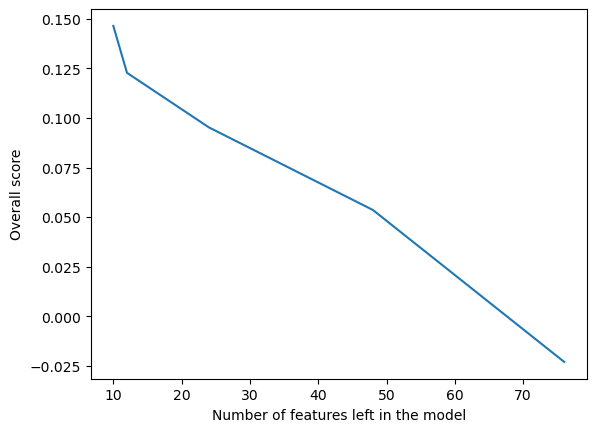

In [118]:
# plot a graph of the overall scores vs the number of features included, to demonstrate the value of pruning the dataset

from matplotlib import pyplot as plt
#sort the matrix by the number of features
overall_scores = overall_scores.sort_values(by='n_features')



plt.plot(overall_scores.n_features,overall_scores.overall_score)
plt.xlabel('Number of features left in the model')
plt.ylabel('Overall score')

NameError: name 'outcome_measures' is not defined